In [1]:
import io
import time

import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.mobile_optimizer import optimize_for_mobile

In [2]:
# Directory containing all the phone swing data
folder_containing_sensor_data = './data/'
sensor_parse_interval_ms = 30

## Step 1: Data Loading

This section will load in the sensor data, as well as interpolate the data at a regular interval, which is defined above.

In [3]:
# Organize files that contain the relevant data for each swing type
data = {
    'acc': {
        'Forehand': {
            'Good': {},
            'Bad': {}
        },
        'Backhand': {
            'Good': {},
            'Bad': {}
        },
        'Overhead': {
            'Good': {},
            'Bad': {}
        },
        'Passive': {
            'Good': {

            }
        }
    },
    'bar': {
        'Forehand': {
            'Good': {},
            'Bad': {}
        },
        'Backhand': {
            'Good': {},
            'Bad': {}
        },
        'Overhead': {
            'Good': {},
            'Bad': {}
        },
        'Passive': {
            'Good': {

            }
        }
    }
}

In [4]:
def load_data_file(file_path):
    accel_mode = True
    if 'bar' in file_path:
        accel_mode = False

    loaded_file_data = np.genfromtxt(file_path, dtype='double', delimiter=',')
    loaded_file_data[:, 0] = loaded_file_data[:, 0] - loaded_file_data[0][0]

    new_timestamps = np.arange(0, loaded_file_data[:,0][-1], sensor_parse_interval_ms, dtype='int64')

    # Now, we interpolate the data to be on a common time axis
    if accel_mode:
        new_x = np.interp(x=new_timestamps, xp=loaded_file_data[:,0], fp=loaded_file_data[:,1])
        new_y = np.interp(x=new_timestamps, xp=loaded_file_data[:,0], fp=loaded_file_data[:,2])
        new_z = np.interp(x=new_timestamps, xp=loaded_file_data[:,0], fp=loaded_file_data[:,3])
        aligned_data = np.column_stack((new_timestamps, new_x, new_y, new_z))

    else:
        new_bar = np.interp(x=new_timestamps, xp=loaded_file_data[:,0], fp=loaded_file_data[:,1])
        aligned_data = np.column_stack((new_timestamps, new_bar))

    return aligned_data

In [5]:
all_data_files = glob.glob(os.path.join(folder_containing_sensor_data, '*'))

start_time = time.time()
for data_file in all_data_files:
    swing_success = 'Good'
    data_file_name_only = data_file.split('/')[-1][:-4]
    # data_file_name_only = data_file_name_only.split('\\')[1]
    method, swing_type, timestamp = data_file_name_only.split('_')[:3]

    # Mark as bad if necessary
    if len(data_file_name_only.split('_')) >= 4:
        swing_success = 'Bad'

    data[method][swing_type][swing_success][timestamp] = load_data_file(data_file)
end_time = time.time()

print(f"Loaded Data from {len(all_data_files)//2} Swings in {(end_time-start_time):.2f} Seconds")

Loaded Data from 534 Swings in 0.73 Seconds


## Step 2: Visualize the data

Now that the data has been recorded, it is time to create the classifier.

### Show the raw data of accelerometer

In [6]:
# This prints out one swing acc data, first is time, x, y, z
print(data['acc']['Backhand']['Good']['1650304011612'][0])


[ 0.          1.0097656  -0.89730835  9.944565  ]


### Show what the x, y, z looks like for swings

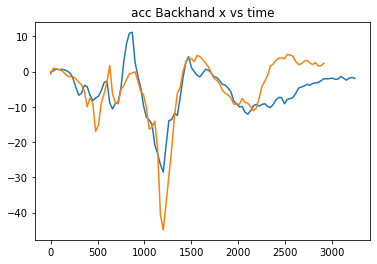

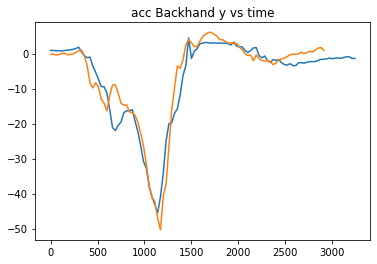

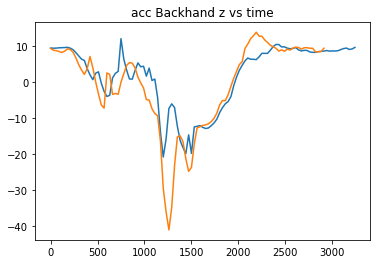

In [7]:
# change num_data to change number of graphs
num_data = 2
sensor = 'acc'
swing = 'Backhand'
isGood = 'Good'

time_stamps = [key for key, value in data[sensor][swing][isGood].items()]
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    x = [t_stamp[1] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(0)
    plt.plot(time, x)
    plt.title(sensor + " " + swing + " " + "x vs time")

for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    y = [t_stamp[2] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(1)
    plt.plot(time, y)
    plt.title(sensor + " " + swing + " " + "y vs time")
    
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    z = [t_stamp[3] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(2)
    plt.plot(time, z)
    plt.title(sensor + " " + swing + " " + "z vs time")

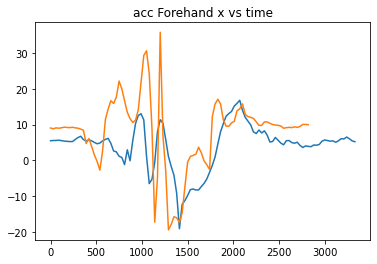

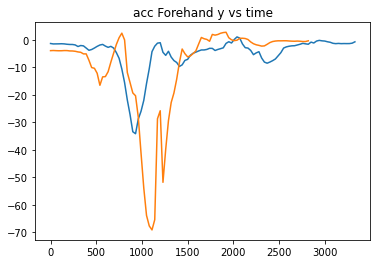

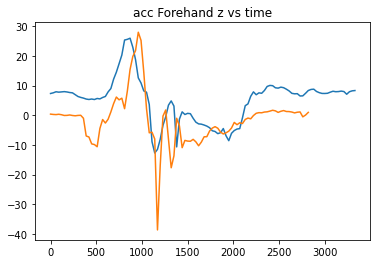

In [8]:
# change num_data to change number of graphs
num_data = 2
sensor = 'acc'
swing = 'Forehand'
isGood = 'Good'

time_stamps = [key for key, value in data[sensor][swing][isGood].items()]
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    x = [t_stamp[1] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(0)
    plt.plot(time, x)
    plt.title(sensor + " " + swing + " " + "x vs time")

for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    y = [t_stamp[2] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(1)
    plt.plot(time, y)
    plt.title(sensor + " " + swing + " " + "y vs time")
    
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    z = [t_stamp[3] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(2)
    plt.plot(time, z)
    plt.title(sensor + " " + swing + " " + "z vs time")

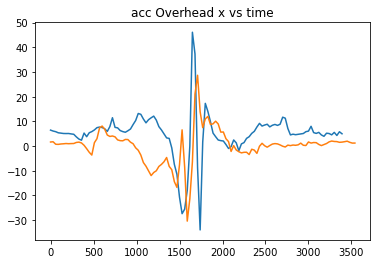

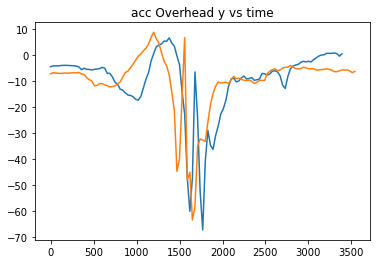

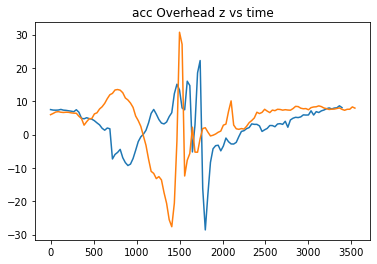

In [9]:
# change num_data to change number of graphs
num_data = 2
sensor = 'acc'
swing = 'Overhead'
isGood = 'Good'

time_stamps = [key for key, value in data[sensor][swing][isGood].items()]
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    x = [t_stamp[1] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(0)
    plt.plot(time, x)
    plt.title(sensor + " " + swing + " " + "x vs time")

for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    y = [t_stamp[2] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(1)
    plt.plot(time, y)
    plt.title(sensor + " " + swing + " " + "y vs time")
    
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    z = [t_stamp[3] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(2)
    plt.plot(time, z)
    plt.title(sensor + " " + swing + " " + "z vs time")

### Show the barometer data for different swings

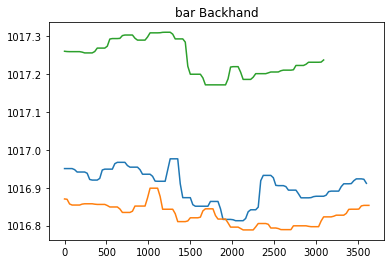

In [10]:
# change num_data to change number of graphs
num_data = 3
sensor = 'bar'
swing = 'Backhand'
isGood = 'Good'

time_stamps = [key for key, value in data[sensor][swing][isGood].items()]
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    x = [t_stamp[1] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(0)
    plt.plot(time, x)
    plt.title(sensor + " " + swing)


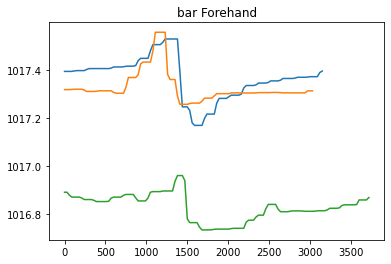

In [11]:
# change num_data to change number of graphs
num_data = 3
sensor = 'bar'
swing = 'Forehand'
isGood = 'Good'

time_stamps = [key for key, value in data[sensor][swing][isGood].items()]
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    x = [t_stamp[1] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(0)
    plt.plot(time, x)
    plt.title(sensor + " " + swing)


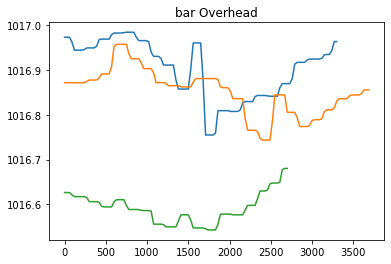

In [12]:
# change num_data to change number of graphs
num_data = 3
sensor = 'bar'
swing = 'Overhead'
isGood = 'Good'

time_stamps = [key for key, value in data[sensor][swing][isGood].items()]
for i in range(num_data):
    time = [t_stamp[0] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    x = [t_stamp[1] for t_stamp in data[sensor][swing][isGood][time_stamps[i]]]
    plt.figure(0)
    plt.plot(time, x)
    plt.title(sensor + " " + swing)


### Show acc & bar magnitude data

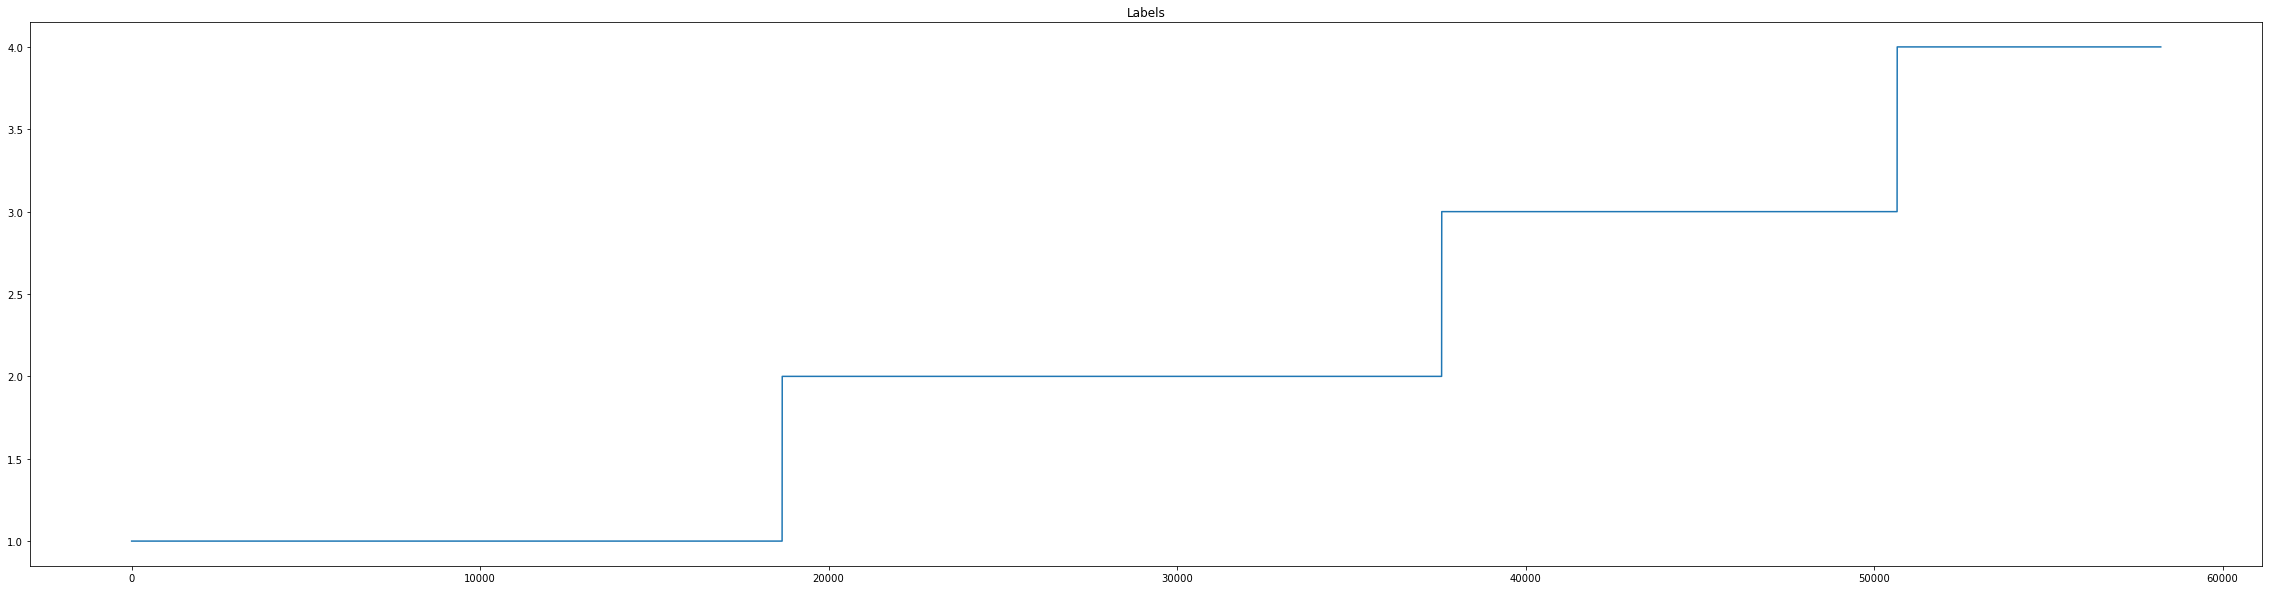

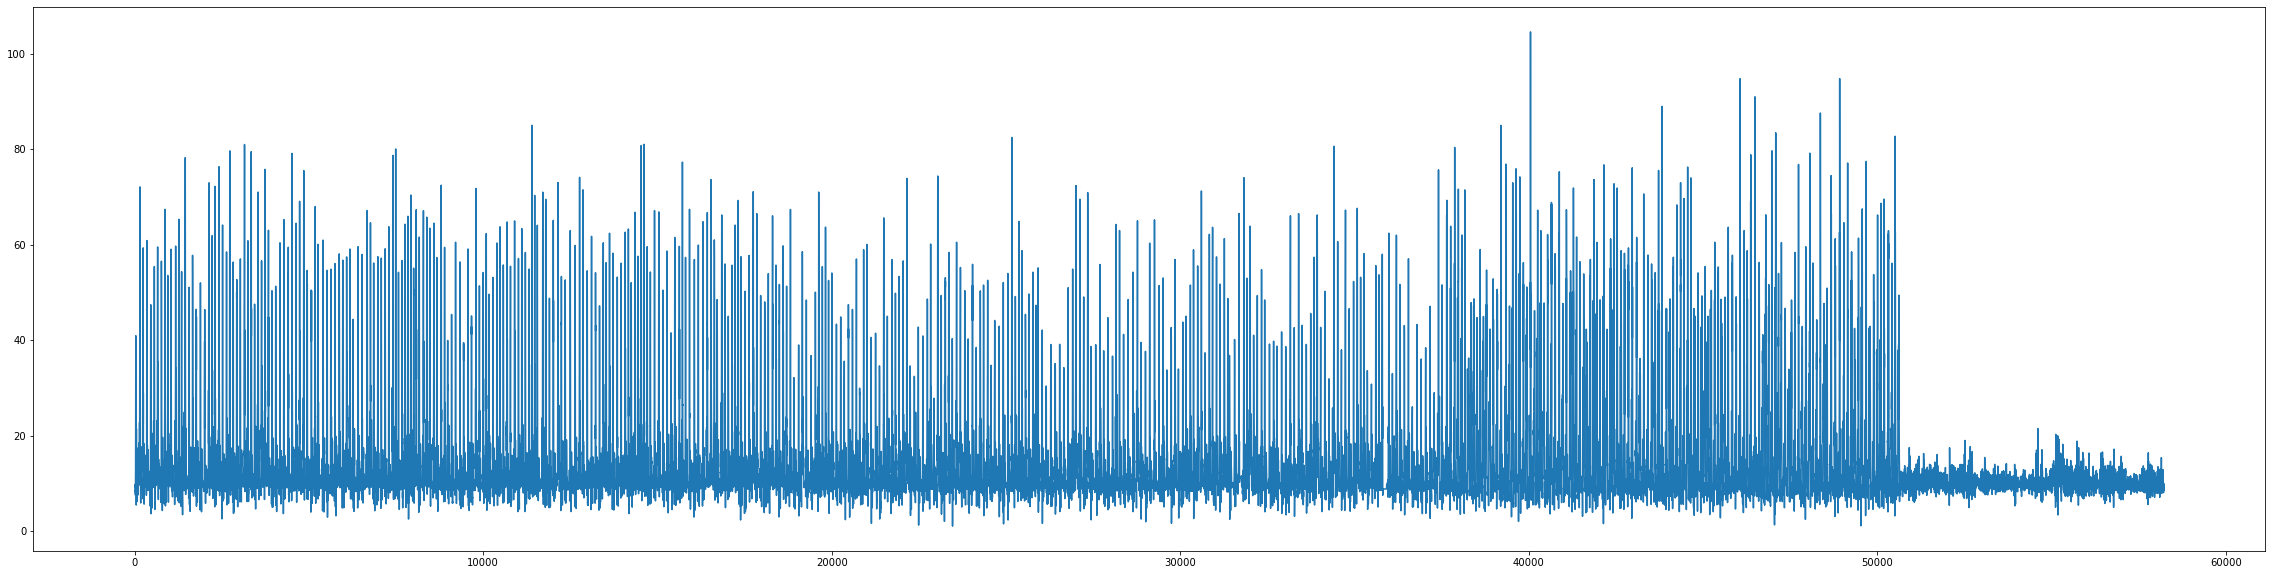

In [13]:
# Visualize the magnitude of the 3D accelerometer values
import math

sensor = 'acc'
swings = ['Forehand', 'Backhand', 'Overhead', 'Passive']
isGood = 'Good'
# forehand label 1, backhand label 2, overhead label 3, passive label 4
activity_label_acc = []
activity_label_bar = []
acc_mag = []
bar_mag = []

for idx, swing in enumerate(swings):
    for key, value in data[sensor][swing][isGood].items():
        for acc_data in value:
            acc_mag.append( math.sqrt(acc_data[1]**2 + acc_data[2]**2 + acc_data[3]**2) )
            activity_label_acc.append(idx+1)
        for bar_data in data['bar'][swing][isGood][key]:
            bar_mag.append(bar_data[1])
            activity_label_bar.append(idx+1)


plt.figure(0, figsize=(40,10))
plt.plot(list(range(len(activity_label_acc))), activity_label_acc)
plt.title("Labels")


plt.figure(1, figsize=(40,10))
plt.plot(list(range(len(activity_label_acc))), acc_mag)



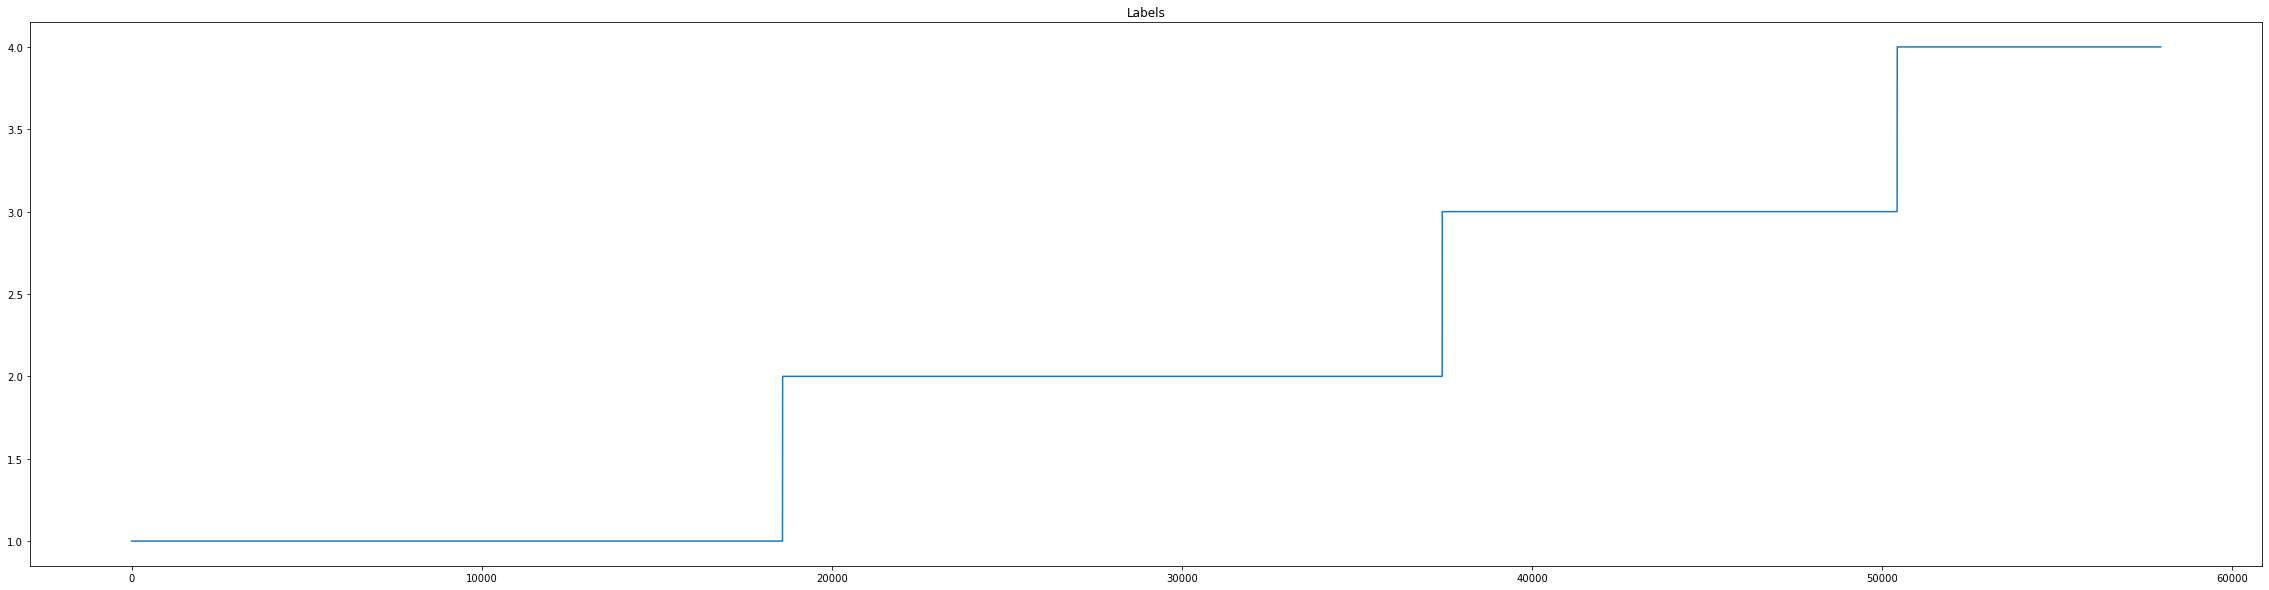

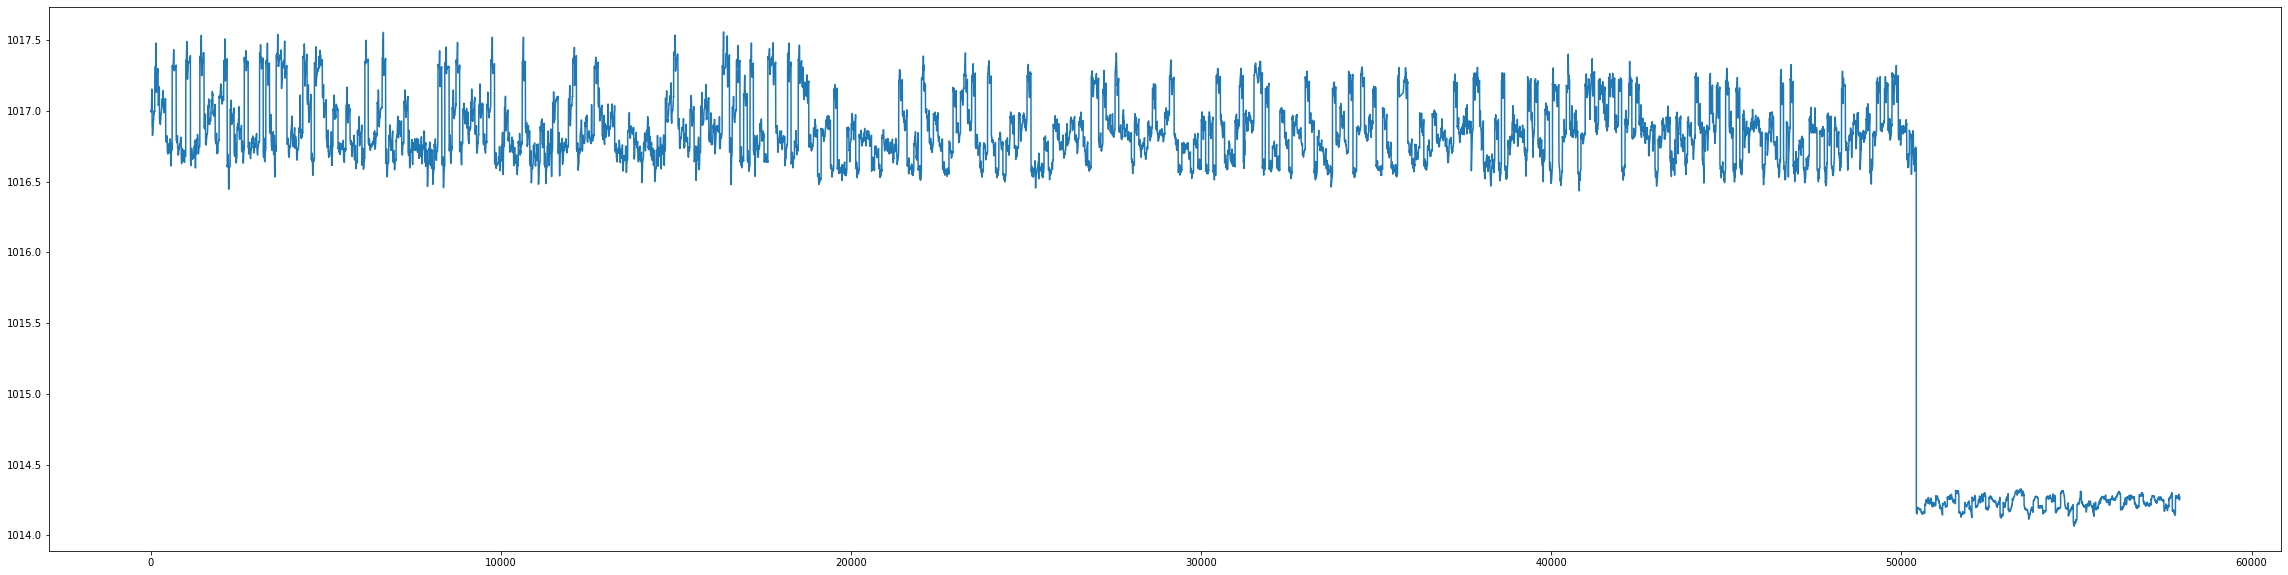

In [14]:
plt.figure(0, figsize=(40,10))
plt.plot(list(range(len(activity_label_bar))), activity_label_bar)
plt.title("Labels")

plt.figure(1, figsize=(40,10))
plt.plot(list(range(len(activity_label_bar))), bar_mag)

58227
1650304860088
1200.0
1800.0
0.0
3300.0
111


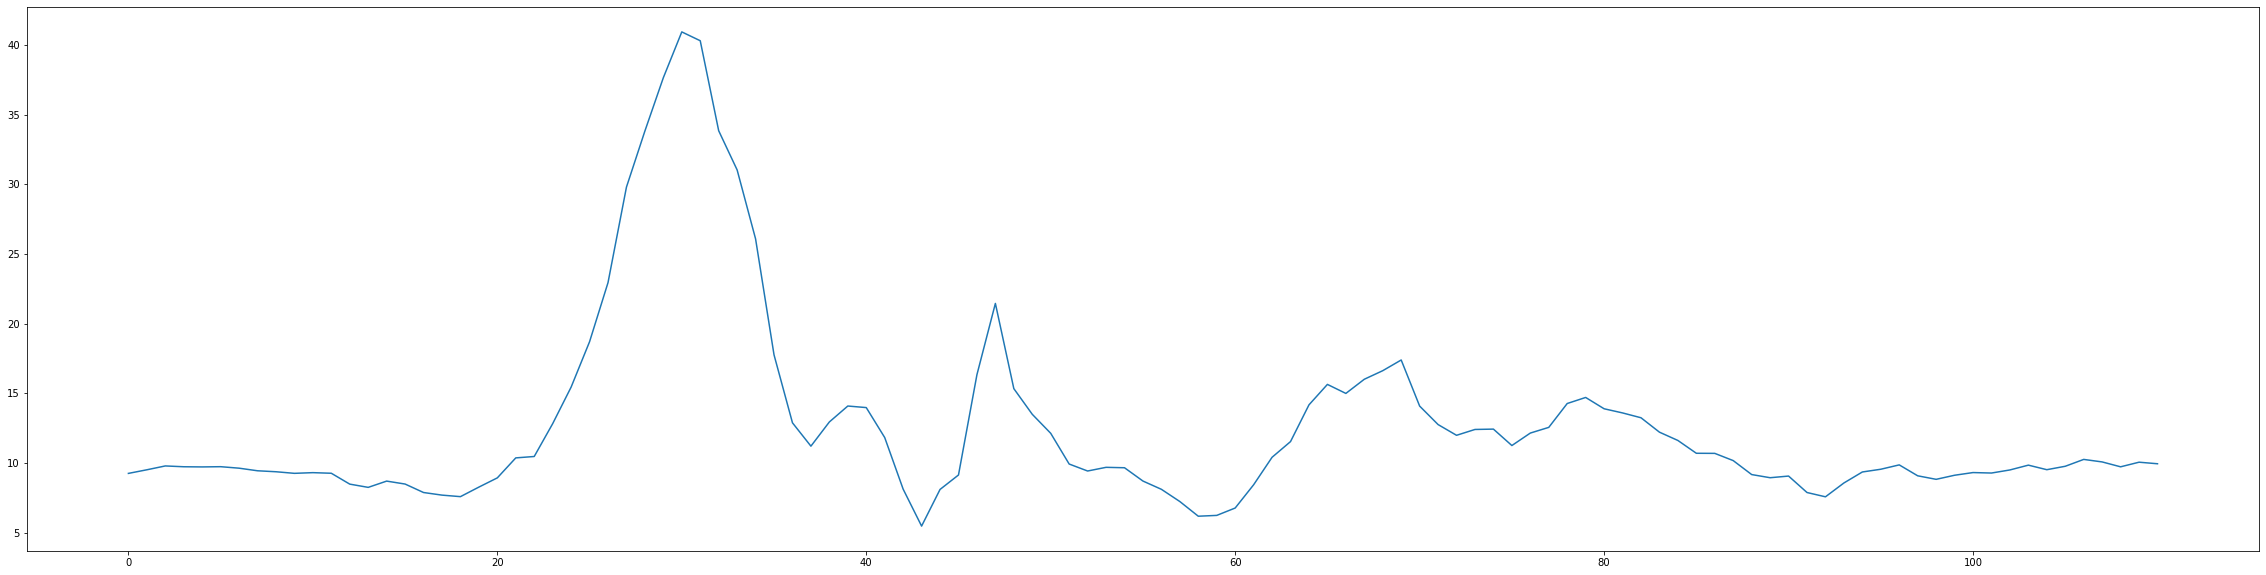

In [15]:
print(len(acc_mag))
print(next(iter(data['acc']['Forehand']['Good'])))
print(data['acc']['Forehand']['Good']['1650303738074'][40][0])
print(data['acc']['Forehand']['Good']['1650303738074'][60][0])
print(data['acc']['Forehand']['Good']['1650303738074'][0][0])
print(data['acc']['Forehand']['Good']['1650303738074'][-1][0])
print(len(data['acc']['Forehand']['Good']['1650303738074']))
temp = len(data['acc']['Forehand']['Good']['1650303738074'])
plt.figure(0, figsize=(40,10))
plt.plot(list(range(temp)), acc_mag[0:temp])


## Windowing & feature engineering

In [16]:
import numpy as np

sensor = 'acc'
swings = ['Forehand', 'Backhand', 'Overhead', 'Passive']
isGood = 'Good'
# forehand label 1, backhand label 2, overhead label 3, passive label 4
activity_label_acc = []
featureMatrix = []


for idx, swing in enumerate(swings):
    for key, value in data[sensor][swing][isGood].items():
        # value is [ [], []] includes each timestamp data
        x = []
        y = []
        z = []
        mag = []
        
        # Get data for each swing
        for acc_data in value:
            mag.append( math.sqrt(acc_data[1]**2 + acc_data[2]**2 + acc_data[3]**2) )
            x.append(acc_data[1])
            y.append(acc_data[2])
            z.append(acc_data[3])
            
        # build the feature matrix row
        activity_label_acc.append(swing)
        featureVector = []
        
        # mean of x,y,z,mag
        featureVector.append(np.mean(x))
        featureVector.append(np.mean(y))
        featureVector.append(np.mean(z))
        featureVector.append(np.mean(mag))
        
#         # peak value
#         featureVector.append(np.max(x))
#         featureVector.append(np.max(y))
#         featureVector.append(np.max(z))
#         featureVector.append(np.max(mag))
        
        # std 
        featureVector.append(np.std(x))
        featureVector.append(np.std(y))
        featureVector.append(np.std(z))
        featureVector.append(np.std(mag))
        # Other features
        
        featureMatrix.append(featureVector)



In [17]:
# forehand label 1, backhand label 2, overhead label 3, passive label 4
# print(np.std([1,2,3]))
print(len(activity_label_acc))
print(len(featureMatrix))

534
534


## Split train and test

In [18]:
import random

temp = list(zip(featureMatrix, activity_label_acc))
random.shuffle(temp)
featureMatrix, activity_label_acc = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
featureMatrix, activity_label_acc = list(featureMatrix), list(activity_label_acc)

# 80-20 split
split_idx = int(len(activity_label_acc)*0.8)
train_x = featureMatrix[0:split_idx]
train_y = activity_label_acc[0:split_idx]

test_x = featureMatrix[split_idx : len(activity_label_acc)]
test_y = activity_label_acc[split_idx : len(activity_label_acc)]
                        

## Train & Test model

In [19]:
sklearn_knn_model = KNeighborsClassifier(n_neighbors=7)
sklearn_knn_model.fit(train_x, train_y)

KNeighborsClassifier(n_neighbors=7)

In [20]:
sklearn_knn_model.score(test_x, test_y)

0.9626168224299065

(array([23.,  0.,  0., 37.,  0.,  0., 37.,  0.,  0., 10.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

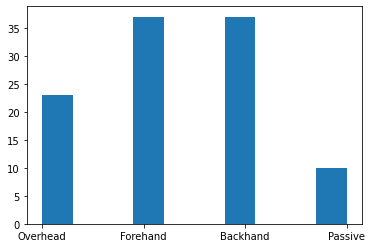

In [21]:
plt.hist(test_y)

In [22]:
false_count = {
     'Forehand': 0,
    'Backhand': 0,
    'Overhead': 0,
    'Passive': 0
}

correct_count = {
     'Forehand': 0,
    'Backhand': 0,
    'Overhead': 0,
    'Passive': 0
}

for i in range(len(test_x)):
    predict_label = sklearn_knn_model.predict([test_x[i]])
    if predict_label != test_y[i]:
        false_count[test_y[i]] += 1
    else:
        correct_count[test_y[i]]+=1

print('Model predict incorrect counts:')
for item in false_count.items():
    print(item)

print('Model predict correct counts:')
for item in correct_count.items():
    print(item)

Model predict incorrect counts:
('Forehand', 1)
('Backhand', 0)
('Overhead', 3)
('Passive', 0)
Model predict correct counts:
('Forehand', 36)
('Backhand', 37)
('Overhead', 20)
('Passive', 10)


### Export model

In [23]:
import pickle
# pickle.dump(sklearn_knn_model, open('model.pkl', 'wb'))

## KNN in pytorch and export

In [24]:
import torch
# https://github.com/Kulbear/pytorch-the-hard-way/blob/master/Solutions/Nearest%20Neighbor.ipynb

In [25]:
def make_y_numeric(vals):
    new_vals = []
    for value in vals:
        if value == 'Forehand':
            new_vals.append(0)
        elif value == 'Backhand':
            new_vals.append(1)
        elif value == 'Overhead':
            new_vals.append(2)
        else:
            new_vals.append(3)
    return np.asarray(new_vals)

In [33]:
class KNearestNeighborTorch(torch.nn.Module):
# class KNearestNeighborTorch(torch.jit.ScriptModule):
    def __init__(self):
        super(KNearestNeighborTorch, self).__init__()
        self.xtr = torch.tensor([[1.51201043839179, -6.90010070644992, 6.240671964162034, 13.813764853780903, 6.544311457961655, 9.024069480889917, 7.223301428280665, 8.629100673431761], [-5.284262859081253, -9.11277297685121, -1.2261278415965944, 18.80957844442508, 7.527582151329532, 15.68014275980136, 12.115460711650245, 14.421684082892655], [0.8428003831571771, -9.781253997479729, 3.1087442144003816, 13.396571816696996, 6.3668686740335625, 9.611414581950637, 5.7409614930919695, 9.615318104119002], [-1.425659159969105, -12.268977144265923, 1.780799815122412, 17.389496064362476, 5.647902207576472, 10.788149587558935, 9.989384544973015, 10.070141670961053], [7.360274830497191, -10.386748875649213, -0.4618722380584451, 19.12721907860579, 7.2656071532818345, 18.201200139039827, 8.214693041554742, 15.747219743298494], [-4.6942246246836214, -6.419898536634153, 4.98647060149722, 16.489995334911356, 9.62454530550074, 11.601830185387797, 9.750213479763579, 11.768465654070473], [9.444523691609284, -7.801714277151884, 1.7715979801398054, 15.705056437882554, 7.151009165100261, 8.710703068997837, 7.14303895832421, 9.197381187358577], [-1.447256395940679, -7.714327746054492, 1.6910629550554745, 11.822990007658113, 5.050027933248826, 7.300862670588521, 5.459746496965507, 5.7702872128195], [8.67953286617619, -6.194547780308201, -0.9369891531555022, 15.001913299350354, 7.385257427418961, 9.784568249756324, 6.1754842113385395, 8.828571082419732], [-1.0061411293963007, -6.636272052210068, 2.1291075754144333, 11.873677384354863, 4.7170046533991625, 8.198449836205818, 6.032622294294035, 5.870141014127366], [2.2964787475229, -5.912758593730325, 3.027181143392203, 11.746951546303995, 5.375657385666231, 8.091802553554592, 4.658847535755899, 5.242833692236571], [9.604034716004872, -7.1904704601413085, -0.581368048197881, 15.027437768037512, 5.645055715093583, 9.527218051005548, 6.8197686051467885, 9.359392760498892], [-0.6722119623360776, -8.304793207437546, 2.6280721324920617, 13.676371130541538, 6.851364367448645, 10.77962255911573, 6.78081376658373, 9.919979159429372], [1.1413731496596415, -7.463862403045435, 3.521895449672915, 13.164437213566384, 5.799390819720974, 10.325565288283618, 7.712531011121601, 9.790131870758348], [-2.3374113999699686, -13.305679437789074, -1.3973898826728914, 18.07304022274901, 6.916822202996439, 10.735112507924265, 9.482968694505812, 10.527786004266963], [-1.2824760279693264, -13.590324769544887, 4.2937898478214445, 20.674798654652427, 8.63172760848293, 19.3135777800188, 8.181123765770328, 17.081650921195887], [9.293683561122982, -7.9786459778247325, 0.8104171878323569, 15.812353911591954, 7.209407928063632, 10.670885883487621, 6.8055519656082675, 10.621510784011834], [-0.48049427282718693, -10.855582433647484, 6.100053627459561, 18.885897313176617, 10.005220548093664, 16.317238944120223, 7.485685746278584, 14.866078760773272], [-5.174311538526435, -9.051162056871043, -3.7135651087248736, 17.698312600117806, 7.304073294989159, 13.786722780421297, 11.049295172051954, 13.219964709658337], [-3.034098798835151, -2.169776004595037, -3.1663366259744357, 12.269000154699452, 5.7881680622436225, 10.415357486573479, 8.04928527758472, 8.954583230615631], [8.864150920597023, -4.799150430976852, -0.5383809170887006, 14.030291511579366, 6.251619617540581, 10.511280547372372, 5.495917299560853, 9.209813465312694], [-2.7267073949495058, -8.949494492730496, 3.4953565531930018, 10.305597418067357, 1.3152309882968645, 1.5225414086171105, 1.837714439155952, 0.982712286058779], [0.3360266069884624, -8.95630100948971, 5.287713555924664, 13.439571426349376, 6.69585193331526, 10.726247278079397, 5.239876719240027, 10.72423414491564], [-3.9686786897586916, -12.735617609218018, 3.4641353689343464, 18.06049755509673, 7.276449889600255, 13.82447372052652, 8.841006288249858, 13.637859699442622], [3.1491123839277995, -5.704160186523737, 3.292953391205647, 12.312637756279386, 6.047286161071427, 9.39513532375222, 6.011216152536749, 7.916426154360788], [1.6082913879152338, -7.680066209924142, 5.342746989102934, 12.828895087288663, 5.696832180525659, 9.252675248340218, 5.617876048307033, 8.669535272702475], [-1.6207027251516581, -7.166902421962569, 1.7512753999508075, 12.321748395014733, 5.757222826797948, 9.591456128864378, 5.536689876310982, 7.812120698085098], [-0.8095444254355518, -9.095756624259845, 3.7033059603307574, 10.017737627799857, 1.0551398972822386, 1.1717536345052855, 1.360059232141939, 1.0409834286156916], [7.992960646798951, -9.430223156547198, -1.471668728215712, 18.721275220814682, 9.85152820538947, 16.335283979715353, 8.428538489784119, 15.473543982842964], [-3.6515444164674697, -9.365087661444807, 3.7838741009650207, 16.349152616557905, 8.430585215089224, 12.571310117890995, 7.890894483248066, 11.808487471274903], [-1.8374635285874654, -8.388558637079306, 2.557225932988294, 12.706020249794955, 6.255784226770801, 8.361797255691005, 6.35525543790377, 8.263437748840174], [-0.9151823071893647, -9.401022068601842, 4.157536238539949, 15.749692464439134, 8.470463864425758, 12.329232616179267, 8.363963094232048, 12.335464444607277], [-1.6679222036239627, -7.901427623976602, 4.870798137789971, 9.699220074609693, 1.5275167688845668, 1.251357657139747, 1.3545848583474096, 0.7735832349778777], [4.917670130168232, -9.831984949610515, 2.7718854519132803, 16.043271444156954, 9.033704524196379, 12.97396800704633, 6.8598761075084855, 12.966794568236853], [0.010245707862135496, -8.347611007846915, 4.912275947425846, 12.973731362037421, 6.677432197721766, 9.646650640949742, 5.533930739635898, 9.683275417801365], [0.8178948188375921, -8.58216429433684, 5.137456203575347, 10.548210342298546, 1.8686594006872383, 2.681851885634333, 2.546508775413624, 2.5729623323065103], [10.41037949892599, -4.720981573663269, 0.01820761925898581, 14.957186916578268, 5.864691336226935, 9.653994476632626, 7.725798270459148, 9.707148506660628], [-5.8718060997947, -7.724659537916746, 4.2844988669709245, 16.459899645722835, 9.225142496038798, 12.923764159845906, 7.797275854761462, 12.429865282090041], [-1.6723667750003184, -13.002415143505976, -0.7593760741080441, 17.229692637509682, 6.720427104421228, 10.426764529266965, 8.417909755647234, 10.015823356165528], [3.2007734969619386, -5.471623508996853, 2.952308253067745, 11.81336715477367, 5.647134261086668, 8.319167653689517, 5.62641091516559, 6.488395093544697], [-3.8923237468514973, -6.296280130121053, 1.8296747270171863, 16.011063359904874, 8.247594470717225, 13.037618703521419, 10.035222530177972, 11.853054229229988], [-0.7847621903688821, -10.691765583971858, 5.045790334614408, 17.616027105504187, 8.25602773851899, 14.940992116349348, 7.990576115765165, 13.612855623230296], [-0.2344304842221771, -12.42333878718098, 1.3345992058837357, 18.626390471694364, 7.538663285270562, 12.454241545100727, 11.244960045584033, 12.149968737758442], [5.831829730571775, -9.669080942406913, 0.3387146755245935, 16.333783905413807, 7.888297058079968, 12.870992194505094, 7.34783632030234, 11.945792747965136], [3.216099754253037, -5.9944796252444865, 2.926678833680157, 11.64345381303884, 5.7018322304226565, 8.06805420407422, 3.709362726308719, 5.535004712284824], [-0.5613937143763409, -8.71944049597748, 5.183629472449575, 13.894871703795623, 6.8152222946572065, 11.06051107375645, 6.022572943356806, 10.733121880630815], [-2.3481041241395726, -7.817254398754165, 2.5220837255911284, 13.245412838359481, 7.637248938104119, 10.547362543843674, 6.510026064855192, 10.46412307419494], [1.0363899415909914, -8.170430858288869, 5.394068865367668, 13.333595745943661, 6.337098712389642, 10.416166619329948, 5.669772821093993, 9.997145537813376], [-0.6043926484965896, -8.652892133694179, 3.9987561336674546, 12.679029272824978, 6.541283766620484, 7.87161605844905, 5.554181604938697, 8.128331074336153], [-0.6488152861001691, -10.452048983856072, 3.684288857246515, 16.376928546622853, 7.316098398443163, 12.808128998285074, 8.776437787002004, 12.23257166095399], [5.930909604423135, -10.127111299127572, 2.5056355737975733, 16.93987053093743, 9.679248432585757, 13.634911279769112, 7.532169127688731, 13.906304168236415], [-4.027921460755301, -7.15839661321223, -3.464632436482436, 17.639768495769097, 7.297257124936041, 12.575113779335652, 13.533397125351653, 12.761086339524676], [-0.2551685137592634, -7.909439050087401, 6.3503385228510325, 15.187349626763067, 7.428534737093176, 11.819805391933166, 7.685343249424837, 11.2361459776731], [3.476231645692644, -5.194654824815179, 2.9225979513076425, 11.400035366973306, 6.105314774660481, 6.634411424637753, 4.216201074311798, 4.088524497702746], [-1.903858726967401, -7.611851706742153, 1.3947958584014113, 12.689220275104306, 6.04577622294619, 7.7213333652649645, 6.632250492581345, 6.530792786945536], [6.369959783330195, -10.166009845038882, 0.4680773065868398, 16.544535542135467, 7.4086114552581455, 12.633669882208704, 8.649631857527341, 12.638625460428475], [-1.8363033627671865, -8.778263739249311, 5.966733580724896, 15.471461457860363, 7.986773027951914, 12.76242697002963, 7.096539425105327, 12.397365513473213], [4.486369564813838, -9.063077408484927, 0.61492627650067, 15.640063317146845, 8.811256520643955, 11.994384847510977, 7.514257775013684, 11.661947393021094], [8.752267228738445, -4.072426118440485, -0.27289851088892464, 13.484674711906026, 4.855732854353811, 10.478754071709378, 5.002773882287587, 8.356735762859106], [-1.4065203545648135, -8.040309017339458, 1.9586658439714817, 12.91711665116783, 6.78292164268576, 9.006180307837454, 6.729522878466012, 8.718665369795433], [-0.8460970735755836, -12.449146296942555, -0.594467433795723, 17.073392022792447, 8.000958617244407, 7.606835577517998, 9.620062024887707, 8.886769931050328], [7.5392616986333945, -7.200419775187282, -0.236119655210669, 16.838048550026137, 8.176900958787861, 15.621350713840648, 7.589956835494765, 13.918266328722025], [-1.793435903789064, -8.564814805173219, 7.409613361186603, 17.31394186489206, 8.46095678121606, 11.861713801996054, 8.316038544216202, 10.637048147502501], [-0.48021457291269226, -8.106034764973542, 5.32874945594902, 10.769138162181658, 2.865660506205555, 2.6777908617004305, 3.0272658961044216, 1.7048614303416536], [-1.852666886261881, -15.006468507996798, -0.08200338426227353, 20.100582799380657, 8.996952907459615, 14.151405224948682, 9.88241678270087, 14.26426865562979], [8.006391409641534, -7.655453789843034, 0.8598910563293091, 15.130669909853784, 7.3655891485457, 10.493595026984057, 6.696020627368761, 10.184038942299413], [-2.041943721221027, -8.268903885252005, 5.509618219989687, 10.733009128306938, 2.2334045961902023, 2.1972947920676993, 1.977186515796629, 1.1950651102225884], [-0.37082002987159374, -9.044760957212002, 4.50683983887523, 14.948173688941425, 6.720464738645534, 11.032576345024175, 8.209189114785637, 10.634006300574248], [-0.5483597348905389, -8.827300031748017, 4.5106511959956945, 10.647448543304213, 2.0699218194699296, 2.308186645378075, 3.174941988007475, 2.2118536422662314], [1.6072877778129862, -6.828875789928763, 5.6451763886108335, 16.62482246317704, 8.480507937217682, 13.741816734734691, 9.280075440155294, 12.311643078832963], [-0.21320751745073843, -8.548883508837893, 4.975753156652413, 14.129952343935166, 7.265432696855622, 10.764293055681135, 6.952359584415275, 10.734209518142004], [3.6302652804268143, -5.5815942725201495, 2.5013735287690952, 11.113756463129077, 5.723553159325884, 6.234218117450943, 3.8129935772912775, 3.6383737798682785], [-1.2818808722542914, -12.314732179225498, 5.164252317345285, 19.39356257413709, 8.3340892688445, 18.427011103734205, 7.891474141406984, 16.58741167812648], [2.255784814645591, -6.713505898708389, 2.818695157415869, 12.156605704278242, 5.93287920256993, 8.472702955880052, 6.509565621613345, 7.725406288091463], [8.909170304521613, -4.905216490017576, -0.13132762753213284, 14.438673866132554, 6.377690102483981, 11.023420037764982, 5.8911981079031746, 9.58505836085554], [0.35492053994161926, -9.410362915141702, 4.142657280539876, 15.809742877001133, 7.101330017748418, 12.837032836977608, 9.048548983406324, 12.368875335906187], [4.267500435041985, -5.578956010355226, 3.4682864250183107, 12.17767731753013, 6.604958175244498, 7.173699573119282, 4.114896935933032, 5.008923123795437], [-2.2125541523415775, -8.963840359677386, 2.080522536891616, 10.318761315074488, 2.016339152592737, 1.8680769965527575, 3.287725968910745, 1.209150987196941], [6.032879376467692, -10.712063139846093, 0.030989545670252437, 18.15198912304559, 8.771533273580825, 16.676683556456695, 8.07117213861567, 15.551384877711973], [-0.7001479288355695, -7.25688334446027, 5.881078548687569, 14.311358841084493, 7.937251626336379, 11.27856010294143, 7.221422310226052, 11.192831526158859], [7.259250852796347, -8.766678555559333, -2.2385344146079396, 17.10992781614017, 8.128420173651739, 14.19382226316386, 6.866150914929595, 12.509700861191222], [-0.12859714465284425, -9.54527013386262, 3.4354224630123915, 10.863798008946068, 2.542997941043221, 2.2408326566428145, 2.4134053037423735, 1.4904476366417105], [-2.667468920063837, -13.49704837747295, 0.12728011294112376, 18.83648655482535, 8.310696383171695, 11.690124938032383, 9.470385251536896, 11.397524823091333], [10.330329999868558, -7.27961291941877, 0.4128548506753908, 16.149203008208836, 8.68058877517896, 10.49579320788183, 6.332443008610368, 11.166749952148903], [-0.13761846329401486, -9.220579739619911, 3.9403899682539287, 10.39026085277053, 1.9157387017222016, 1.568593480938139, 1.8400801384949634, 1.457263629969036], [-2.6415207715494726, -8.301490033684695, 4.446582964227138, 10.180016011535594, 2.364165784417551, 0.9776839018149671, 1.3575676639289855, 0.6479802919471614], [7.870126137676881, -7.1121710857975735, -0.015616887041100811, 15.750146357434689, 8.330340188767961, 11.574292195252362, 6.88442918128989, 10.733553429178318], [-5.050892053339544, -5.337417876718122, 1.0776346589383263, 9.92989976599191, 2.941028715815515, 1.0589958579074785, 5.893387270743896, 1.0300790639463315], [7.154296127854204, -7.417399493168477, -1.0465484508635023, 15.13863306287392, 7.564081366471912, 11.266932563400033, 7.059816591769838, 10.588622553958164], [9.352466986731244, -7.118621280961972, -0.33156400147456494, 14.8640387219598, 5.633738391496663, 9.200276415323827, 6.523956208970975, 8.732685396690652], [-5.498489594597606, -6.848472468380236, -2.613953279127789, 16.52616345176549, 7.640045220469289, 12.226882125397037, 10.823356939621725, 11.656141265645356], [7.9636548672240925, -9.55362503770336, -1.7637547083257747, 17.358531586495026, 7.098726186751414, 14.677377839851331, 6.406432652314957, 12.780589778799989], [9.468040569880165, -7.243852880594426, -0.048361552872346183, 15.401621979534845, 6.022957051948544, 10.559618524748567, 6.810861336986847, 9.953841631118623], [7.746426921741363, -8.631799441768404, -1.8402889971106235, 17.30737037828456, 8.752661267537938, 16.411149575966785, 7.763121685370639, 15.638339227982065], [-1.8693008233348838, -11.161818731157021, 3.382225736405975, 17.63410482150313, 7.853365312264018, 12.162112749298974, 9.61252459952109, 11.425902304085476], [8.825446315141352, -8.130829576278801, 0.34887708546716606, 15.96911794676822, 7.632588568018534, 9.939867375840928, 6.913911642018678, 9.693679661227566], [0.3795738286840474, -8.67526128827239, 4.433097849767898, 13.585146468480104, 6.92107707778997, 11.26916032819235, 5.539709799896647, 10.774231006111927], [1.1522666656830698, -8.99083688153785, 4.444510803747104, 13.805176065679996, 7.112085543161403, 10.249566872445007, 6.240326607474472, 10.291293135140402], [-0.03500246734365531, -9.526851537027353, 4.861145708854366, 14.998981280117913, 7.08441135424231, 10.3750454067974, 7.026481128781101, 9.82981749703464], [-0.6653266749044334, -9.341213348107487, 4.455250196354818, 15.44819662615239, 7.6773883382705845, 12.169760866859427, 7.388188929144238, 11.425152454866417], [9.997342961044163, -7.720060952660988, 0.2536446963324319, 15.571695061316673, 6.43325662520532, 9.324935424553809, 7.049419482321682, 9.755428358532848], [-4.8651662048841935, -2.261673195902034, -0.13747844373949528, 14.602941654426044, 8.250615392526058, 12.39659548677103, 9.628887157111558, 11.402706043239842], [8.210290024394657, -7.941483648084389, -1.0993608519055873, 15.928440681812031, 6.775902301430804, 12.58864118351405, 5.9877461288451626, 10.872407235541981], [4.802658451104316, -10.351281650130533, 1.1395383501193523, 16.265469660206502, 8.868053230965964, 12.811192466889587, 6.0876352421623325, 12.115111545303183], [-3.6506385139188966, -9.053388899257993, 3.420606532299227, 10.79024228927748, 2.0141383193515936, 1.8895881760756386, 2.015205393360354, 1.5001939641545896], [8.101435050448902, -7.7743281832098114, 0.8967553716545106, 16.426294954902566, 6.847342816916992, 14.505477267505256, 6.224798390412666, 12.373258351776487], [2.635329136057055, -5.572594365797242, 3.920990477249065, 12.049485998126135, 5.364495254739576, 8.761214526392866, 6.217311580978371, 7.237021053947199], [-0.7499386577647958, -8.986743335540508, 5.47738743671411, 15.528290547165668, 7.036706834977294, 11.977500301406101, 7.109085118656039, 10.663619336785557], [-6.233093193777504, -9.133396690789196, -4.620263231601958, 19.073246216333168, 8.882239463374745, 13.159543348240899, 13.48417563812469, 14.619139804818145], [3.4185933563396476, -5.9005496305495795, 3.3663713163171485, 14.316666012788618, 8.5560101127472, 11.592564986297655, 8.202115285959815, 11.302051308117335], [-3.7861577207403507, -8.15520880535205, 3.97946170026419, 10.543800232106951, 2.0938244581852836, 2.1155051247304266, 2.808680883013361, 1.5016537988380125], [1.375843538822842, -8.46249399926404, 5.951571150540753, 13.854802150525813, 6.327451682156966, 10.657243268818386, 6.234109891765067, 10.461835961438299], [-3.522794333976985, -12.348723492394255, 4.707496759953421, 18.177750179978204, 5.562129116401146, 14.268085643786883, 10.021861129960982, 13.841395330838653], [-1.3577788782236249, -13.066006370107342, -1.7332441121425977, 17.734539580422343, 6.594393637912027, 10.405532324790544, 9.519759368690304, 10.170608429209564], [2.9272268267988624, -6.934270064653264, 6.659956160370833, 13.927979630495646, 6.552056180805676, 9.84018373651605, 7.645015174262004, 10.257878478280107], [-0.5439539607195121, -10.408534948655399, 4.7429495409640925, 17.885608176887065, 8.249564245074989, 15.706754294437568, 7.991629481082288, 13.778884520966185], [1.2125833844132372, -10.302680031164897, 4.553612238785739, 15.620320376399764, 7.888922929219759, 14.467371266574842, 6.976149423666662, 14.302557364960224], [-1.5594538308108061, -12.377813198610504, -0.24483434341225374, 16.91466485682906, 6.6964427434077916, 10.392131799663847, 8.601183121725448, 9.819129916533903], [4.570462515837597, -5.288143867011946, 5.725318387729404, 13.096800948827068, 6.239345127788352, 8.56440842239272, 6.952596152445145, 8.40974323167896], [8.62738243750555, -7.870981055951548, -0.6990845365545212, 15.016608371433197, 6.354554070275488, 10.377674177310674, 6.146618492880007, 9.860611561859105], [-2.0385737623547073, -9.422232025568555, 2.979093563536316, 10.576791277769505, 1.9547097038508823, 2.085149442889237, 2.2287259717140193, 1.7540472449497653], [1.1438543023439864, -8.956487667232562, 5.4944052954107825, 16.841284391027617, 7.226130376573977, 14.62090504843595, 7.5195422216986785, 12.272654296751847], [-0.41348849794243464, -9.794724000118045, 4.047742749502616, 15.531958007963343, 7.312948887374362, 11.964771744180656, 8.887991694502155, 12.119466715275324], [0.36041362959208384, -8.17531957401264, 5.982848363639757, 14.229877938136202, 6.526402079684874, 9.24744120377671, 8.269143383086323, 9.836596044503612], [2.038164685918736, -5.797848668459874, 3.2832759360979873, 11.950766811248808, 5.587042819716207, 8.293856819607502, 6.051087658996737, 6.5074578934755385], [-2.0554391343805274, -9.917760038245827, 4.190154035753524, 15.355674268865872, 8.804062437044944, 12.499416458549392, 6.444101611457766, 12.634113565329173], [-0.3195407716627005, -8.397017222010229, 4.287860061242369, 12.57008854245092, 6.733275341328636, 8.848779638802245, 4.712827674794331, 8.765800880796089], [2.167878954088127, -5.899403934566242, 3.140962618710889, 12.160119155788776, 5.552399315606998, 8.77853624754968, 6.410682631930225, 7.105526218989019], [2.782509962689238, -5.549522542081473, 4.034644874869199, 12.109241694411908, 5.189462707136424, 8.625014385682924, 6.6363919053850635, 7.31760075803656], [7.721478968033499, -6.555249402283927, 0.49719863344711196, 15.948331707668023, 8.713638451400385, 12.74018507728931, 7.733016028422639, 12.104949490368389], [-0.8818198959506849, -9.488735344160062, 0.6114170457742508, 10.7157575151674, 3.3031807327970646, 2.3022397866489257, 3.5154501443882227, 2.220310146541192], [0.027400223586782787, -9.041600733027977, 3.8739567682597063, 13.659296863096598, 7.096975795751783, 10.443852493867855, 6.323941039189465, 10.469756227448203], [8.485996177069449, -8.856806562298452, 1.0367268026483996, 17.94084210287704, 8.500102987242995, 15.454263859049572, 7.579013358429752, 14.077769937326504], [9.756701278320923, -6.804071794537497, -0.14767077128129297, 15.341630878398407, 6.730167036260929, 10.767761734258134, 7.720233679957292, 11.26883448463713], [8.788386881315253, -8.43774442067008, -0.047916315989883516, 17.323343837543614, 8.396561350668573, 14.195789396046912, 7.903709590847641, 13.521339931113223], [7.427731514352008, -8.28743528463974, -0.9806810521383617, 15.601133662376448, 8.046937533432331, 12.337343645432837, 6.618078325057407, 11.923982364551533], [-3.902743911437286, -11.58548065761824, 4.2633468606808345, 16.651974573863182, 4.846125401612985, 12.294475156202795, 8.693004456514034, 11.855379311005517], [2.9529643309722298, -5.64986251862318, 2.135246884805752, 11.626534893774776, 5.855401861245952, 7.874579341558422, 4.333636966323923, 5.009895264505843], [-0.29470663891462956, -9.303420995884029, 4.6203843950880294, 15.993390160248929, 7.731326274024776, 13.540078336393341, 8.345625167794088, 12.84353939233707], [-0.07721927479054831, -9.576336497799964, 3.7164374265347724, 13.333650314779195, 6.8674075225199775, 9.056746317038717, 5.198493212904523, 9.162321298677792], [-1.3983992032843724, -7.65941676129591, 2.7570266209466405, 12.39567823892201, 5.8081145318227145, 8.846436699188255, 6.194302896710096, 8.05813671417884], [8.576322613402771, -7.205710291648139, -0.7454155896793722, 15.449421368350542, 6.9256546674681925, 12.380166935067209, 5.256204620426242, 10.779958584603365], [-1.6233890798539035, -6.925656712254902, 0.340722090473587, 15.912677366652003, 7.87615640201304, 13.695510978266118, 12.07043160664369, 13.88521095856342], [-3.103150995484801, -12.827107420652794, 4.320038743648065, 18.624335124715767, 7.869827042182119, 15.79036007328129, 9.09668288867714, 15.491300632468908], [-0.9199787407456382, -9.110107209876109, 0.371352265100995, 10.25415986428049, 2.9885143850691525, 2.244670819250569, 3.2933221263367534, 1.9095177888186525], [1.0795813073220255, -14.361484749906461, -1.393555064010051, 19.412014149278274, 8.744768036253413, 12.007845715535725, 9.553234229032808, 12.019028803373276], [-5.445512612118505, -6.476999201421033, 1.9255065338401027, 15.313193656166513, 6.395108045613635, 11.667618085130348, 8.77350333818768, 9.737755452119169], [0.8217335021814315, -8.88870203505093, 4.274081181641715, 15.74631623243646, 7.520731882037014, 12.045419081610103, 9.136503527116982, 11.624749049593442], [1.9269570157905436, -6.739875474236593, 3.4175298864400174, 12.985351105227853, 6.446196527051348, 9.114204465263155, 7.097986834267422, 8.197733939755194], [-5.57426284362427, -6.434128032168675, 2.157618134460369, 16.52156129457965, 9.500541949138713, 12.394657534798261, 10.218988995266274, 12.348251171943238], [9.14049019993623, -6.4369199440037805, 0.49097994286862895, 15.60468110285486, 5.923053881878161, 12.061017128121698, 7.0976794297170365, 10.613446338614658], [0.9300740995664558, -8.631621782681044, 5.341793315828052, 15.771458386872538, 6.3671896204926925, 13.11903557799712, 7.299409328279454, 11.004424715174737], [-2.3813548194036107, -12.907486764706208, 0.7071833022597751, 16.960793653208267, 6.788267806384954, 8.782670074384852, 8.265078311571822, 8.75403022477994], [4.31792599453582, -10.651919892488612, 2.800703152783383, 18.047498340831947, 10.911188329803474, 16.696804636388645, 7.712940989018498, 16.47927178646594], [2.557168811687377, -6.599855811933799, 3.5542019643984912, 12.490827844868791, 7.053945321550106, 7.7674880737236585, 5.484712420855308, 6.847106420796305], [-1.7919093321938795, -8.175164946137736, 4.605960626126903, 9.611473453214156, 0.7722387933573849, 0.8870233964149136, 0.6239977903175316, 0.8069998767213719], [-3.371181495707882, -12.627794800375828, -1.2151077608200398, 17.63198040854846, 6.080151538085132, 11.186797898395437, 9.438259449457682, 10.611750624721216], [0.732743835385123, -9.058757769958916, 3.611371312180349, 14.610569250248542, 6.1007004767983775, 9.843603574606144, 8.231997106688391, 9.167994808427295], [-1.3823042704620778, -7.250267446158946, 2.6590953157347514, 12.033375812448629, 5.120302151145093, 8.0245363289689, 5.723699395348398, 6.333814788402247], [2.9655093218485997, -5.911708355205337, 2.6027646478110467, 12.224336092953513, 6.369059268688895, 8.286240704889849, 5.8064712979070645, 6.635084176877366], [1.9709438356613564, -6.802685314909338, 3.2400286144872092, 12.252323351460134, 5.288427308238758, 8.437553144366596, 6.370625368050244, 7.091131013424919], [7.572488257238365, -8.534862147597195, 0.4200929990246431, 16.195809829933573, 7.818226436116603, 12.30893043232758, 6.08905555425336, 10.85217503093335], [-1.3860741087840658, -6.595232789366017, 3.027897475449617, 12.116243399613186, 4.554887702911515, 8.009254608517292, 6.119763575693453, 5.489059443721536], [1.7314450999653561, -9.93964666915724, 3.966804560750924, 14.360393345160654, 5.836743643202789, 11.559899582510724, 6.519535101146599, 11.023262315967308], [-2.8903873958922137, -13.06052071277035, 5.164526771644372, 19.037440123971734, 6.202442504657955, 14.54518657184126, 10.361647828828694, 14.162494203006322], [9.30995969568006, -7.266125374966625, 0.2044371328639275, 15.796004993858237, 7.0668922565970895, 10.784287952111407, 6.762120209271127, 10.097923093401954], [5.775521173283577, -6.97454718431531, 4.238212989284536, 13.701557498792605, 6.3972018545273315, 9.297336136602981, 6.319693984813451, 8.918178489206566], [-3.098345661162761, -11.323188547039194, 2.1125596029137292, 17.77891550136737, 8.861069776237347, 12.04382879574843, 9.507232457380805, 11.83838059103816], [-1.5357132023710176, -15.764498077940853, 0.3656379285797522, 19.369846587404847, 6.673769373017935, 11.777507053197317, 8.617332776975193, 11.546767650993505], [-4.636870394589193, -8.039766585291181, 1.3209901982635093, 10.257888970872019, 2.2778801126475146, 1.8353332033811853, 3.2563990070902498, 1.349245357879608], [4.757465723737067, -9.345821810757219, 1.6340758409589327, 17.11218055725306, 10.349941923067362, 15.391686131514222, 7.512571325324083, 14.842013797356838], [-1.6627818480756473, -7.201963360102341, 1.4929100233558388, 12.316623449384075, 5.459736523541032, 7.911777600620177, 6.161678817135706, 5.961033502016827], [-4.760792355318106, -6.313809707627216, -0.4266516065622966, 16.793318894045477, 9.240969111756415, 12.68716977141462, 12.012476345906054, 13.090270581043994], [-0.846745746055737, -9.13233521329303, 4.093172287448372, 15.063899619596757, 6.683437865495566, 11.02646629635389, 8.684630879717888, 10.75284272345602], [8.396534848843235, -8.476059842460062, -2.4616986766639397, 17.850267833025654, 9.205946717380037, 14.232319460862003, 7.1834572265355945, 12.987829553450391], [9.211298042244856, -7.2910833186967166, 0.8454112139974913, 15.114483394808877, 6.42847155043529, 10.292499083878086, 5.806999695324339, 9.55285552805678], [-3.237051766792002, -11.686757212554319, 2.929667127609659, 18.39739756284952, 9.7871840215956, 13.72072512452658, 8.546772394099763, 13.201215779278575], [-1.1087201307578882, -12.378183833159834, -0.40089456113314226, 16.755208064446652, 7.031884918222771, 10.826157417210448, 8.02761746986221, 10.24539636470361], [7.445240093841896, -7.915701214106761, -1.1299775611148901, 16.287468771218126, 7.762937304626412, 13.639438885073229, 7.61288832481293, 12.583270378659938], [0.5958252026328775, -8.975210658675302, 6.307502574487373, 15.788149512543441, 6.804691109079157, 13.339127117014552, 7.0166664887871715, 12.037361824135434], [-1.9349822007898059, -8.666034196902032, 4.122742944130314, 10.05170807064326, 1.460731636475733, 1.293169252852432, 1.4519758918004333, 0.8477833956169867], [-0.9032719938897924, -8.99053281189842, 4.072034692178552, 10.299960142774685, 1.5541297845090594, 2.0848309362199897, 1.8294537812926426, 1.4988691356920865], [-5.71092443965463, -7.231668293607508, 0.42165444312937833, 10.322927609266321, 2.8071065872627514, 1.4226653967839684, 3.709537820343183, 1.480249091027395], [-0.1598495711524221, -11.168551605421044, 5.685028748173201, 17.92253730646283, 8.861101358429913, 13.904451486418054, 7.213091200180957, 12.639061606741384], [-0.852218709273181, -9.259629638691296, 3.6104751460321087, 10.434265018082087, 1.458335575429647, 2.333248390537264, 2.1268300078144184, 1.650108684710766], [0.7404274514004893, -9.279953876718569, 5.708571138033247, 17.780134984637982, 8.560144233513828, 16.124455097783652, 7.479942199689912, 13.868814583105264], [0.3735764697054925, -8.6299523254088, 4.602314066697414, 12.612703781423555, 6.1588627590027025, 8.527698107286126, 4.9932384796867755, 8.50307536226733], [4.014536087194017, -5.861995016914099, 5.048640896154425, 13.242568892733324, 6.814843965644431, 7.624479337698952, 7.801999188847095, 8.127029247092242], [-1.1777018486875424, -9.235573630405638, 4.9626280456206775, 15.419674637288969, 7.405407428655675, 12.086605353654774, 7.320357648051547, 11.316264285582319], [0.8714315314234152, -8.584490350943312, 4.760869690299492, 12.482464165869976, 5.262932976601697, 7.806164945996969, 5.104103598781279, 7.482872729279017], [3.1722460963508166, -6.030825547026517, 2.6680320392320773, 11.922957021559588, 6.201709780668449, 7.919367979204036, 5.225587060261081, 6.315049201466404], [5.559516169821606, -7.988679975322846, 3.080302748690002, 14.536620673858113, 8.04560405639566, 10.279429771292863, 7.082950472918762, 10.652171640357311], [1.490208513974632, -8.300637484161596, 4.472349834936737, 13.291772636458465, 6.328629583080032, 10.022546907286928, 6.188424236775474, 9.65668632234973], [2.068631436140706, -8.367397511625912, 4.593074169891028, 13.961952226167785, 6.951958886548849, 10.538228179987755, 6.34626248336021, 10.005589964711751], [2.5654706937781375, -5.837474845678263, 3.014507445296049, 12.217641216922743, 5.51026987956285, 9.006633653892951, 6.557413484396761, 7.413261509838965], [3.57937845792721, -6.329428524160122, 2.518886990559306, 12.147103492926618, 6.338551348908361, 7.077094783790039, 4.694756647786402, 4.895868437192196], [-3.6621552717402333, -7.802573422343388, -1.6535226922034116, 17.436924502420776, 8.168355825307522, 15.14655206685037, 10.87268725197765, 13.687028125852068], [3.9141934882756497, -6.1424780723544465, 3.1872806966563454, 12.057265873255979, 5.393134250443995, 8.360493047640892, 5.490736858122414, 6.853026902181063], [9.599783199817397, -8.828519676239997, 1.4492418993034148, 17.152105346532984, 8.707460875981099, 11.318492645070396, 7.4983860251823335, 11.754068447447812], [-5.064056592854385, -7.837731728077948, 5.2708665733244295, 16.754596344565226, 9.661147231871801, 13.175424784968596, 7.946384401395256, 12.814634319262831], [7.558678635031958, -8.481233530791046, -0.9960118445341749, 17.27716881847289, 10.67952767241809, 14.145293640145209, 7.7755241916346165, 14.358162906532117], [1.1660335639905128, -8.260792570645274, 4.436516959916749, 13.265807701065988, 6.4849617143482705, 9.871844502711948, 6.1909701939034525, 9.546596838959722], [1.0658850293329194, -10.441146413771385, 4.323501898473183, 14.693290949779264, 7.110021134780998, 11.007857067079856, 6.57877905883554, 11.31190393842118], [5.828771064897556, -9.672687435446363, 1.6933932102941278, 16.433505887401115, 7.48702220731647, 13.84905771267694, 8.3213829865876, 13.320669466495604], [-2.1886984428501375, -9.1476876204886, 2.7995077435656763, 10.13886971449142, 1.9672711102441989, 1.19471088404473, 1.5656198071877954, 1.1224122651427948], [-3.315155957637003, -11.380699391872017, 4.047163206429092, 17.127053800290753, 7.430426431330468, 13.837299378167756, 8.300510366487648, 13.384121158658747], [-0.20942926722610783, -9.626457374822055, 4.6643809841810455, 14.228315051654373, 7.828023835088372, 11.232542021086344, 5.678119213992768, 11.476630088583844], [-1.5484993022028881, -7.013509920392066, 3.14736131333012, 11.970616686681026, 5.594014971339839, 7.71917409129398, 5.560522188474037, 6.324195603343731], [6.745412370913886, -8.429821997972672, 0.014887090717157506, 16.346260234504363, 7.912982150537455, 13.052582154751898, 5.869890260108677, 10.807556802048474], [-3.2292249362896888, -6.948733584733242, 5.824693398257274, 9.804888300424476, 1.481437942460716, 1.8382137089645627, 0.8407635947185325, 1.6687067327866305], [7.775453818621091, -8.044060708421563, -0.8174312896218414, 15.836030429385218, 6.710945052471413, 12.364375708275652, 6.620718722490367, 10.8074703549971], [-1.392398195588874, -8.191697593554228, 4.44008683641139, 14.839215783007772, 8.94197705944795, 12.14628627572146, 6.769101426614367, 11.91078026020099], [4.089445502893456, -10.721535380094377, 1.5615651685166114, 17.257349888194774, 11.471297657070615, 14.519046301226874, 7.144073272267141, 15.156794001156854], [0.5265432211431352, -8.884360729131187, 3.7113500058946127, 15.368525909968382, 7.408596860169989, 11.648720398124373, 7.9279898704973935, 10.498793325275695], [3.0295477058392484, -6.2416897037857355, 2.65833011210422, 12.002758841378542, 6.23431456662093, 7.828271804111892, 4.708564593801837, 5.784154815491146], [4.535846591337762, -8.666374083821646, 4.01204055318605, 14.85617430269726, 8.044741277929875, 11.389565179241613, 6.648851329134348, 11.389371349952825], [9.374560147157416, -5.870545178516215, -0.2977408577186884, 14.370346169041033, 7.195266999643254, 8.119606443395323, 6.415144264466063, 8.647625753445203], [-3.4121405286412165, -13.590622895467538, 2.3700372383454615, 19.669179586251474, 9.160353438603673, 15.765393866702395, 9.408413598397493, 15.364444341395538], [-0.15177001381818805, -8.044816544842645, 5.288161154355345, 13.065508217318087, 6.913223118042829, 9.298359507373606, 5.7732943352018, 9.464793800393903], [9.680467782127337, -7.323337449599615, -0.00939308349622925, 14.69262565681298, 5.669194948823351, 8.080324462368452, 6.1209584611743155, 8.14660141952629], [-6.057715094890998, -7.950329949826374, -0.5788385790467453, 17.664828559548635, 9.587255224381849, 14.838291719343653, 11.173349347768108, 15.004220875386157], [5.6331742926231225, -6.082100356641617, 3.81852026613689, 12.69570198031947, 6.363371666058532, 6.6013179987025135, 6.221814099566349, 6.701172627167087], [-2.4529293904516454, -8.269309873946609, 0.8475284859975318, 13.260669492363823, 5.72519529317658, 8.918870397279488, 5.915012786705903, 6.825158174733757], [-3.8675705657524024, -12.408903827574106, 1.870525055186794, 18.456824359226715, 8.18115631323033, 14.952805214023707, 8.235461510395872, 13.788546823978566], [0.8497002029450311, -7.694330175780041, 6.571639633695669, 14.339998541391381, 6.765640903094132, 11.596060059795457, 6.221575966823203, 10.79009313434378], [-2.147872524752872, -13.55705416730749, -0.2823607241169024, 17.492322871302633, 7.1649333012292535, 10.769749648677383, 7.867357768420815, 10.569982837502907], [3.508650279632898, -5.252120461598099, 3.0676928065490907, 11.957893924131811, 6.172145234356735, 7.626274998808354, 5.514155532543499, 5.742496545144106], [9.053608924739825, -5.872514899979441, -0.42071043815498965, 14.415937071660744, 6.230502641623227, 9.935082788138532, 6.563561201376721, 9.456076895306927], [5.941123898390592, -9.29638391851387, 2.424216142846735, 15.631166301027001, 6.308949697750056, 12.07584802070259, 7.277497788865917, 11.03875431777079], [-0.28272491166246755, -8.896351786525766, 4.255579467532015, 10.33109230486061, 1.4803613704151377, 2.5689244067074557, 2.066392605460607, 1.9142407561541412], [1.7744974663627766, -6.333403422349222, 3.1688395883435243, 12.43196125265937, 6.088615601056144, 8.903590202244587, 6.775318868942172, 7.810174653626887], [-5.256502802843846, -7.77329127832065, -2.021533199692411, 17.217094933968013, 9.063647032846259, 12.656112737810567, 10.947882471477962, 12.565672894978633], [1.6383500427462823, -5.8711894685620205, 3.4186150503397013, 11.594863277798693, 5.693081957732825, 7.699058966456232, 5.43162995926312, 5.9657712184329235], [5.726798506901457, -10.009117517922261, 1.2678942333119194, 16.70624212568889, 5.971241930991236, 13.225583117083946, 8.309336811489292, 11.62344792576822], [0.9090325742521872, -9.574953240542444, 4.6667655996974595, 14.840786097470598, 6.575942387949926, 12.467441933782004, 6.999065406636571, 11.903901972862014], [-1.6304815454679245, -8.075352060844835, 4.670795964625679, 9.95732939258301, 2.368476161242428, 1.2449791343494183, 1.7227187576250618, 0.8155486353864859], [-1.5093301366238216, -8.27528639711092, 2.452158244394415, 13.130953391915874, 6.585031442301339, 9.724975017178402, 6.692988650661985, 9.331851946379446], [-4.982305704569058, -11.820120327967672, 1.9681350628691932, 18.69209384334543, 11.236116067881788, 12.91679317448596, 7.9176479283475425, 13.221225245766885], [6.117001992510833, -9.29330553277121, 2.634110300923111, 17.128633640943278, 11.08140575815745, 13.887583227382684, 6.6839457829236295, 14.059492895444757], [-1.1991443217914686, -9.405898665417594, 3.5801877722856954, 10.729524668625164, 2.010707778216848, 2.4035736599143984, 2.5866996419299757, 2.0285583117953414], [3.4019169086513585, -6.639037469697577, 2.5993636065461003, 13.079910016092137, 6.971894756042324, 9.935406956196184, 6.202578894541847, 8.781464292756832], [9.36876094479068, -6.741333150042897, -0.279180148236936, 14.824893203012715, 5.140825454789375, 9.931693256247646, 6.665827717848159, 9.111509963325375], [-1.2874803244573974, -7.317273409403574, 2.2724467644617428, 12.35688635618879, 5.458662067259806, 8.235374514639648, 6.159380791730876, 6.574787168406142], [4.549230128563614, -8.285168454772046, 4.819858338725948, 14.55592393516496, 5.750819006294268, 9.550339505754684, 8.889983839726808, 10.198447944398032], [-0.8921698312397504, -9.332121616860576, 0.9034595566285908, 11.143583572569614, 3.72563570494815, 2.655076336099195, 4.694137035815786, 2.736048149939414], [1.0675980655054345, -6.587780760102776, 3.0626689795945894, 12.276151632890354, 5.144079294338009, 9.489994723181317, 6.262905061053935, 7.678554211160261], [-3.2225818720835755, -6.866826168723757, 4.934882551651203, 16.9297008423795, 11.219383735014253, 15.870142430262904, 7.138426200643016, 14.96561898192779], [-4.443488442974189, -11.452675465061027, 4.33040603940022, 16.860061337734667, 7.045182402273464, 11.837229789391882, 8.545938523408907, 12.173199350163015], [-1.5945386938597004, -9.259109407134181, 0.4459605522622663, 10.447246207591474, 3.1939169859324865, 2.4309060484115825, 3.0409360453558065, 2.164553097711481], [1.162885166884252, -14.220827705256964, -0.9813549466755426, 19.622352266072063, 8.941534296397709, 12.903899482008855, 9.605928058461384, 12.579590728290217], [7.11992036901575, -8.165405483417151, -0.4415011652556734, 17.772916003857237, 8.14822715966584, 17.444387118248194, 8.072272667996435, 15.412570407683578], [2.7013886020709363, -7.366506308064315, 4.463639181287941, 13.176191639392902, 5.155677026398014, 7.646684000160419, 8.374805876186633, 7.941355013567852], [8.940711683198254, -4.407275518977522, -0.8626200965394571, 15.011264105835828, 6.891746392455939, 11.618821088593442, 7.735066364274812, 10.820854391611764], [4.271439281309193, -7.754702169285107, 4.058919229045214, 14.44855283628026, 6.804827158671105, 11.11267541600367, 6.800533776047272, 10.106395634119854], [-6.022931162267499, -6.241790741657822, 1.9137154451993343, 16.366615294281935, 7.6183770062247325, 14.17797602705568, 10.3040213523677, 13.276271710273868], [-1.993076820840881, -8.483170130828118, 1.1350890274544891, 13.26674602338717, 5.91325026932496, 9.45257014903446, 6.334875910756649, 8.103497498507027], [8.859585827253273, -7.607269052806044, -1.213861276151364, 15.852017034778546, 7.931862130490939, 12.141778243132899, 7.067069795446188, 12.117363981300459], [7.946936572634702, -8.226751777244345, -0.5226669056225534, 17.026032169205397, 7.903100160218607, 14.11738751161631, 6.763176837002552, 12.195115341211142], [0.14562441566377426, -8.489600658776908, 4.667303642865841, 14.49226763798378, 6.853199805924629, 10.186105550984308, 8.315496729344398, 10.184449300338024], [-0.5934886144798546, -8.895352746028543, 4.125102543007953, 13.044537379034923, 6.1929224283643585, 8.781337385986195, 6.169312326481554, 8.936477708863858], [3.128403601161938, -6.087900256522003, 2.7122862346651817, 12.066622288821513, 5.7615110013104935, 8.336988423511533, 5.301477092292704, 6.277627428805033], [8.839594221244228, -9.115573030770916, -0.7494612583132373, 17.256606891499686, 6.9566627086117325, 14.050459163902005, 6.65122437258057, 12.411794908787655], [5.0920417271363965, -10.140635725999033, 1.4876603120966791, 15.951693866015738, 8.057203463302375, 12.24554686944495, 6.963614156720405, 11.82716558571458], [-1.1783348967431089, -8.65966009749404, 1.054329404152911, 11.221062954475336, 4.307065566890212, 2.9936118139795296, 5.21666408619348, 2.510707564740622], [-4.6620641895729, -7.739784141499862, 3.603302908684253, 10.11241892644093, 2.126885564799272, 0.9609260855437177, 1.7068247771224638, 0.849793116017945], [-1.5040907834368509, -7.892323325046718, 2.789354152004017, 12.382283555419871, 4.881178292982672, 8.067065233302676, 6.295720338009656, 6.895661293237309], [-2.486166487718401, -8.581995765810953, 3.8771088591733838, 9.930417950288271, 1.0362437486767901, 2.0303836700686624, 1.4696796118440383, 1.899122082265296], [-4.611240971181175, -7.741272156380746, 3.063875588163444, 10.01375684034677, 2.257691782308552, 1.0002561666526641, 2.1683314891154675, 1.0498530778769963], [1.349951037046811, -6.3963514596845945, 2.8334611293146255, 11.751030903952541, 5.446106292253063, 8.136498757783519, 5.490113861335496, 6.219444545639227], [-3.018049853745204, -9.341858262017077, 6.226870735973048, 16.98390271517112, 7.418372500481361, 13.385871580024196, 8.832184084463986, 12.606394910761969], [-5.1759885742442595, -6.049000734300311, 1.68207873126781, 15.802439268103676, 8.089993332202138, 12.086234145130092, 10.191270003082225, 11.483927979661773], [-1.0469434322767326, -8.608397237304539, 4.139838836255098, 9.833573106552645, 1.2011290291743237, 1.2909794996737511, 1.4527004327575312, 0.9270257032614614], [8.352998067522323, -4.202090636717022, 2.7297875202451736, 14.001579351955654, 6.412729913966995, 9.383414821875482, 5.23274100897445, 7.442500596417478], [8.034540218130282, -7.73395959915612, 2.345026924493341, 17.29293576153707, 7.990700900276353, 15.756133722291395, 8.974119035657688, 14.948690740016072], [-2.770526989960595, -6.735563479406926, 5.98366903188497, 15.823496997361906, 7.8360122960422265, 12.716975872245852, 7.542868866540961, 10.885049739053994], [3.0699605578886016, -6.572515915935985, 2.958088913059026, 12.166786233985428, 6.074628993422346, 8.080768425125951, 5.004594183182238, 6.370881001311386], [-1.2131735933628693, -9.36578214030089, 0.915497739880374, 10.584397172159035, 3.1681254673903547, 2.3066477584695764, 3.215671201239326, 1.922634134251769], [3.36581369259432, -5.768791249830345, 3.5722429435555667, 12.232258376477, 5.611385836766433, 8.54219978921846, 6.634379929472197, 7.497483194568413], [-1.3537186592170787, -9.108510168343255, 2.98339379619611, 10.30560310574029, 2.3830047008252557, 1.2335185547919885, 2.5257615087089076, 1.035589442447794], [8.371089095665022, -8.715429053084407, -0.9349609738509014, 17.917176762786035, 7.56779428153793, 15.703406608352415, 7.3891289084886305, 13.577572703609466], [0.8839540984834305, -8.364552515516893, 4.97618437344027, 13.548981703377537, 6.529857913505933, 9.702217169340587, 6.65618976166023, 9.644249264091599], [9.743143930291994, -8.013214477505995, -0.6730820481240941, 16.73611251369097, 6.258749919337564, 12.206157792227073, 8.712606304899502, 11.981977487343613], [1.227556352638137, -8.151467182924943, 5.027676091652996, 14.045948716046206, 7.5290447557308235, 10.186815520414589, 6.845671886446086, 10.1618459120191], [-1.7961643766279778, -9.096777262433674, 1.1142674525523015, 10.106105238353308, 2.7360052435055677, 1.8795316030398062, 2.535038419002467, 1.5907782442806744], [4.868935554854487, -10.68216759417645, 1.017476723997935, 16.447993848103117, 9.223585634414654, 12.371213991806009, 7.044728523769138, 12.492544287057099], [-0.8274962091914116, -14.485229986600169, 5.3888078947122, 22.017024109569988, 9.207319418080578, 19.014704235836987, 11.480212394850536, 18.246246800354687], [-0.5523883365671298, -14.205718716615424, 3.397913217730404, 22.030731000657394, 7.811678680259663, 18.7292086634982, 13.385086418099073, 17.868027376471442], [10.114299492405321, -6.030745644959231, 0.8883144901078736, 15.444329090706512, 7.488328313538611, 9.065390492217098, 7.0652816541408825, 9.439561398053478], [8.740057214340535, -7.892436038323902, -2.6809976985718182, 17.777499243492308, 8.341120705352747, 13.907248733071965, 8.375939549539725, 12.765956341719864], [-4.128085052349949, -13.098424328861292, 5.087830131120521, 21.147901883119495, 8.43239364931259, 18.147399398654382, 12.758737844508305, 18.179131620062783], [-4.283788654148381, -6.775718463091541, 3.5691868836411724, 16.479591457147265, 9.271916178438504, 12.347898609941394, 9.329466444274003, 11.441212356065332], [-1.1141217780698882, -8.27711302083418, 4.823447063027681, 10.102923649455851, 1.6112503639621047, 2.377054370832169, 2.040637905121938, 1.8328013739107538], [8.460231205505274, -8.372066759942255, -1.3057655782067763, 17.746953597447465, 9.576907577466004, 14.346699336982242, 7.794378782341693, 13.664368146918552], [-3.6973160885120833, -11.49297445634921, 6.530935499389699, 18.638092227535296, 8.130026334075556, 14.220259044356279, 6.969946054303969, 12.566880607732724], [7.635271209595428, -8.78598594056854, -1.0206766139353292, 17.105839540084737, 7.108443055332336, 13.317919319899284, 7.305425647721278, 11.188794901493456], [-0.9598141781982026, -11.750520044778947, -0.5062864390013804, 16.548762044903295, 6.345115984666238, 7.387731518864529, 10.205313385240112, 8.023606449942516], [1.0902095563908585, -9.064997640071098, 4.413725139982131, 12.957298343917637, 5.613420541557897, 8.96716624597111, 5.614100604315092, 8.853858739781137], [4.073351646294088, -5.430113989467177, 2.3042815609442937, 11.817486153747515, 6.474839154794417, 6.85260153032744, 4.60697002699661, 4.673427942593906], [0.8380554681985375, -6.391504842843886, 7.010073047544449, 13.383403977486152, 6.291568237993192, 7.199387464865785, 8.133057971505329, 8.315102883407338], [1.096554898420266, -8.816887181004033, 4.339625024360899, 13.482051867259475, 6.489150379970909, 10.750486793449639, 5.580409838369652, 10.23863115472824], [0.14820336494485187, -9.992601522987599, 3.876443946474866, 15.372793285611309, 6.875314485690314, 11.634578854162132, 8.490072628084938, 11.54525016288679], [0.03320419391394513, -14.071829863537387, -0.70103144933952, 20.355919102084957, 10.022063502872617, 13.415652588439977, 10.881558115979901, 13.526836255752778], [7.367123242970278, -5.91925780686821, -0.7587071440657226, 15.274336595009942, 7.122107180884539, 12.974805220914622, 6.002993067614624, 10.568268683213406], [-2.0920016066403386, -8.628065715340684, 1.3771868241323297, 13.13406946273875, 6.725765428630879, 8.381845414801289, 6.633400308274884, 8.228371917661057], [-3.2036490189476683, -13.130415575540702, 0.8942613430779712, 18.30951311428389, 6.748142555305193, 12.117155145530127, 9.926990811011786, 11.795788927412897], [2.0213345296153564, -8.463766713340194, 3.8306746015399584, 13.713432078242906, 6.862083066871824, 11.408376362760825, 6.140157920213942, 10.829485829575543], [-6.062167229510358, -7.555449757779519, 4.818947681106839, 17.70535680727175, 11.318909517011287, 14.090883814172741, 7.930354883161198, 13.897429169922162], [0.09626217430901188, -8.354875687667521, 4.716396009102699, 12.810397226257816, 6.24990845090416, 8.480706400944458, 5.365163904258112, 8.229219209986097], [-4.172807256532206, -7.822261446206794, -1.0341842615274912, 16.12639804586348, 7.450394256142584, 12.900637475902359, 12.571733448833584, 14.127711118623662], [-3.1845110588182703, -9.491963240972082, 4.166818114305253, 16.77007237563323, 7.651621808766774, 11.664092216619055, 9.24361837981094, 10.789270914162545], [-4.469012473858021, -6.388650431643342, 4.933758414029498, 16.641941608982595, 9.798894648491054, 12.45771227881419, 9.387765434617434, 12.145688527613338], [3.2766837327568124, -5.868561148589533, 2.937629821184876, 11.924223446458186, 5.696737026213153, 8.536143282964826, 4.92846981452692, 6.420872215699014], [5.515257467408157, -9.759724779008234, 0.9869601483564495, 16.64630772482717, 10.518282194964735, 13.575592479771053, 6.627320226241152, 13.725784751680521], [0.8177394722879053, -9.014584775585735, 3.7267964696567915, 12.812700276327018, 5.838174029577934, 9.450421909125764, 4.938978052644518, 8.913103530232467], [2.8779167693243215, -5.937896106370856, 1.8944591786239124, 11.426995989666937, 5.954888038978873, 6.935796450673564, 4.274852518644741, 4.288832166328426], [-1.609698006528014, -8.96628951633013, 3.9497551966552664, 14.716315260718831, 6.415697412446948, 11.828945067517113, 6.859432778307247, 10.495381811160707], [8.844657399591377, -7.623451645709272, -0.819375013152191, 15.76766930276927, 6.879952284016889, 10.592106588787077, 6.886557864241539, 9.764635390910534], [-0.9095789191212473, -9.258190202124721, 3.9982668655613383, 10.507280976702305, 1.7692848482481938, 2.338868375658798, 1.8979493130067397, 2.0802619501744677], [-0.5842253904023983, -9.569716234236674, 3.4255641136122033, 10.866310300369765, 2.0917905838576005, 2.6758377119813863, 2.734066466791734, 2.1422868191634956], [0.48558047216733397, -9.508621731960375, 6.687623830386816, 16.11050619915965, 7.008540714462383, 11.736619962331593, 6.390917875460391, 10.17532802996601], [7.665997721539265, -6.583728332344339, 3.5542413840992517, 15.867478629120702, 8.091903064179776, 12.297779736036672, 6.955041313108583, 11.316166970083275], [-3.066010625161795, -13.63622235593222, -0.6156520524539185, 18.248757692464125, 5.918710786470891, 13.347496060469465, 9.397148985660952, 12.814134732485693], [7.917779863121247, -7.456083963912887, -0.7775917948171472, 15.643450338071892, 6.963493867342867, 11.857298779960557, 6.597582074791152, 10.333702482111333], [5.232082377312118, -6.317109251100122, 4.78501198686681, 13.258767080107791, 6.325042592237289, 9.028726263142145, 6.684674013584996, 8.977244505943395], [-5.009059325627613, -5.626211853047511, 2.130649265014601, 15.945944215617576, 6.971514050063833, 15.065271565081321, 11.522738416876548, 14.674787242396281], [-2.528027365473035, -7.565756289757329, 5.083266945327446, 9.8528333839953, 2.3801440143539105, 1.1444180973193323, 1.211407984640695, 0.9138683477708667], [-1.5503742346804545, -9.098558533895, 0.5591030881556399, 10.607372191701057, 3.4514067909397372, 2.296187204285748, 3.827955168980688, 2.1958152020567137], [8.21659527629205, -7.788263428506704, -1.2249683085599263, 16.122870707453096, 6.725673485207598, 12.925328722618248, 6.1378987297445, 10.940552084236465], [1.1396800100745355, -7.582430308032638, 4.752479847192472, 12.636373971826108, 6.523994999175741, 8.811472771102084, 5.885356651070429, 8.748841266082275], [9.32094737815883, -4.584159329937975, -1.902848002761531, 13.772856866799668, 5.398870671858378, 8.203695491793958, 7.073820574488996, 8.265057943567182], [-4.191319528707837, -5.688692723825033, 0.9792053350382316, 15.15478325624242, 6.910850120811287, 12.508494554753348, 10.474654063455622, 11.625852012217782], [7.669073598297644, -6.4063436833231275, -0.7596853419024757, 14.89744407556903, 6.802549061577722, 12.236760262813746, 5.973108898502328, 10.497152778590582], [-1.040589916041918, -9.225514222174786, 2.8379958108591095, 10.567611337734611, 2.6453365526141286, 2.2742652423829157, 2.89723386537156, 1.7711021466638759], [4.729567445426764, -9.607281302267006, 0.9323455693351483, 16.88423496087704, 11.227821704238533, 13.002507763623493, 7.817216260394596, 13.663769564630504], [3.2630972862019867, -6.326461352595104, 2.8407045321280053, 11.94944781620175, 6.530078329064385, 7.3976273492627165, 4.819680011229601, 6.045522728825379], [6.057756557379366, -10.67456497064637, 0.5195580419354763, 16.147691419242395, 5.675801190040402, 12.327312884629709, 7.429343684869116, 11.381443840796955], [5.664954368404285, -8.780589691734459, 0.562774106187517, 14.944923751652139, 6.035705800672823, 10.920086022233797, 7.096716598662761, 9.601970725303861], [-0.17704220515691163, -11.524763129543736, 3.0819129456334236, 16.73804398948603, 7.013603307569735, 13.975109144284964, 9.606024060957612, 14.10523254524072], [0.19505772578431343, -7.778772087584484, 4.55825334525182, 12.951513101626185, 6.942268365398624, 9.972903298729518, 5.931063654921471, 9.819100314521252], [-2.6390040855097254, -9.287449841848227, 3.6882526968386387, 17.804097407776666, 8.303918266295973, 12.479176357308049, 10.057674680183482, 10.755468919616911], [-2.368618082863276, -14.827681424004293, -1.283411870649589, 19.448618947727677, 7.521955453358289, 12.502365945859262, 10.184294073129056, 12.863812379870158], [1.0758060972085282, -8.201496240520013, 5.089499832349041, 13.64367439735132, 6.825784808173304, 11.167218654846089, 5.693039889110494, 10.577517229304393], [-2.8951324821962583, -12.604447052198381, 4.401498676919678, 18.490140623690817, 5.833521310228818, 14.191314091165234, 10.04439824519925, 13.455670571151968], [-1.0975932093919165, -7.7559028180522995, 5.483784602606943, 9.802333845204364, 1.3703083320073948, 1.5259553805185704, 1.4236672835915667, 1.2561836704066436], [-5.24472825250339, -11.422980750477775, 4.355948914671912, 19.46379124524743, 9.117166071136165, 16.326672565866534, 10.503908848015964, 16.0667930934016], [4.555497307573827, -9.954152721740915, 0.44929369551544657, 16.62897045626773, 9.784932079690352, 13.11468339324096, 7.60019949750795, 13.000760255749773], [-1.333782047162293, -9.98396226174314, 5.866886761750709, 16.07950719156867, 8.283533103140435, 14.314847051348382, 7.1702714757233155, 14.222265837574303], [0.7440010691373926, -9.20020226441016, 6.041111440303241, 17.079229873866666, 7.993744259763084, 14.64292122900107, 7.1680608934186925, 12.636786776222124], [0.2228063291546592, -8.487317366013384, 5.657396523514471, 13.621420950768963, 6.816009595012893, 11.54304232673785, 5.729297553819815, 11.448663190711168], [2.180623094160329, -7.5427341532910415, 4.6655403067921055, 13.69017021296378, 7.301287452171975, 11.059266352998407, 6.496987424243371, 10.668714908412005], [-0.5388675399566766, -8.261393149259519, 4.724384694823582, 18.373489697057945, 11.589402765152464, 16.729888871575582, 8.742637166534674, 15.617708693111975], [-1.224512222633712, -6.978802965385319, 1.9241215574286092, 12.027652493128645, 5.550210415911562, 8.262433252694787, 5.801249024420871, 6.478276734195746], [-1.5581390547634815, -11.13503138473812, 3.782982822507826, 18.302232896101575, 7.836642335236299, 13.223022095299246, 10.37707657703617, 12.235233794831696], [5.382264197940623, -3.1705610393524704, 3.4317925203625417, 12.03728841987437, 6.411622032742037, 7.755303474489157, 4.849905901136832, 5.538711846839163], [3.007320743624652, -5.621822294417171, 3.396123817656145, 12.075870363117852, 6.266797655057456, 8.13791591102442, 4.863963641607002, 5.959232035613079], [2.4142564777880984, -5.836841037955089, 2.7412001872784995, 11.71155246325371, 5.372953548224727, 7.907147342462397, 5.70685648873101, 5.849007173858834], [3.6745906138359343, -5.670261910538348, 3.9485193686538476, 11.622833222126996, 5.715600594670302, 7.269791323451972, 4.776521333741447, 5.872661364719489], [-5.94609543887044, -7.306581629825991, 4.9616300271135065, 16.508434396038293, 7.57135780441598, 11.834612732962679, 8.978341159330824, 10.900719238387335], [1.5052220432939833, -8.585849428795619, 5.104345292346463, 13.832134906296577, 7.4760215997747945, 10.951953638348083, 5.861186614800081, 10.995389242833385], [-4.888482023591209, -7.078944324543951, 2.289834610563625, 16.86636996824213, 9.210308388737948, 13.309920871684268, 10.660663093504374, 13.054161317466622], [0.6679018765412135, -9.39769180193057, 3.8169149297468135, 15.19478731211266, 7.462265050320308, 9.973742931270436, 8.739789823210945, 10.197786825362904], [5.711072275921229, -8.126504319258144, -0.014161386422593998, 14.616272946595544, 5.9894918459762545, 10.724115342334732, 6.577036480009636, 8.897148756500298], [-0.8805761764759094, -9.53157223777051, 4.475242781418712, 15.157365161796719, 7.379877071390497, 11.672346527212126, 6.564765605692557, 10.756894046556656], [-1.3330582713500687, -7.4217089354122345, 2.3516136541274917, 12.80531013018788, 6.627299009209078, 9.562901202319482, 6.497333344337525, 8.717708372904339], [8.59453082866288, -9.46844742969934, -1.3646952805223698, 17.67633630849423, 7.292497729859749, 14.005704943574488, 6.56224000950324, 12.055300612606338], [10.0334195681132, -8.270182387118416, 1.2026222340485935, 16.295032484914795, 7.299180333831523, 10.122994678517701, 6.806828799125655, 10.347444834696974], [8.669403536522257, -8.272313267678111, -1.5815533677621014, 17.290520396426924, 7.717286912406826, 13.400463597344148, 7.120553233850699, 11.702997915993363], [5.5269294900688175, -8.668402249477863, -0.028064119061870483, 15.240639600547347, 8.925416189952381, 12.18785415314385, 7.570792391200529, 12.606965525485572], [-2.190910917600356, -7.646028200034825, 2.7483293030151943, 12.142602821779763, 5.441425902697363, 7.462138537666679, 6.035470253071004, 6.715048558311947], [0.11435661474815512, -9.408997077630092, 4.003602587636949, 15.469983587743071, 7.270062837329882, 11.605680381030378, 8.65446887625373, 11.300274652073039], [9.367064955654255, -8.828456530185763, -0.22407813108009653, 16.42702313993157, 5.712508493989733, 11.776002644923192, 7.287912679754652, 10.96847004703383], [-3.3564822265224774, -13.303954798204918, -0.1879445105620628, 17.21821666074218, 5.286857632991318, 8.092186875055473, 9.097017161761855, 8.247399448684432], [-0.9805689079661202, -9.565771177105635, 3.4271212720429234, 10.889202649942098, 1.8255746610704844, 2.7115917446252116, 2.828248168340458, 2.0785475198275507], [7.723471704350335, -8.2427373601037, 3.946720222842234, 16.890610372976127, 8.247635299566339, 12.449520043563036, 6.673957339133902, 11.199748212150233], [-0.23564867312211105, -9.193330431594358, 6.08314397943082, 16.38548799758429, 8.014933003817253, 13.786104030623445, 7.28660262246002, 12.668215014500742], [1.9358211545377944, -6.209990335572402, 4.973315198965014, 13.118420076384917, 8.323093350319082, 10.431572033786527, 5.739513417100709, 10.294945097342588], [3.4949580779381892, -7.412388084034643, 4.1173352456304855, 14.824286215498509, 6.481303251462485, 12.160781153571124, 8.249016479648061, 11.058452865783275], [-0.1110798963781519, -8.896567801866853, 4.756724637467399, 13.588314530323157, 6.251637546357622, 7.372875437218721, 7.028058865488093, 7.744757616531883], [7.743564485783857, -9.05939407053704, -1.2897791978382127, 17.38622014887287, 7.4465863106780725, 15.654310837684424, 7.742656826146491, 14.20831170116889], [0.6416191146041305, -9.905211641923497, 4.86747710625494, 15.03002736686094, 7.773694810497083, 10.207749660905442, 7.01748493937399, 10.49709876640467], [1.1555505460663362, -6.860689955500994, 5.342654796135276, 13.779690953276017, 6.584269798565642, 11.249946052415034, 6.83382217060486, 10.182507630976742], [2.975541945783129, -6.578853594940173, 2.144287341624857, 12.132342681768746, 6.352992971228592, 8.316967154362242, 4.983956874569811, 6.626589033367696], [2.8472215498141185, -5.400085890346936, 2.15539548083626, 11.617440782300443, 5.879063936752255, 7.428807614442603, 5.050752650907538, 4.712650550472915], [9.590461828845196, -7.189885963516078, -0.12217185378359147, 15.227861660259334, 6.996410401127046, 9.973346251234554, 6.272277435372192, 9.977847044881734], [10.259779997349971, -4.9474386535063735, -0.06501644457733219, 14.06756227976129, 5.766378383764121, 7.533927714895294, 5.407391243644349, 7.148371843097236], [7.269851340697567, -6.34685820297145, -0.030630215977328352, 15.13683666455672, 7.4223137331907525, 11.403668470820698, 6.440438347815847, 9.519669291705958], [9.717283933055835, -6.5087054815271745, -0.47261799840426777, 15.175118345157646, 5.942212895555869, 10.975087542029742, 7.496771129606469, 10.894586870771677], [-3.90550017582264, -12.048987000484214, 3.948823773552122, 18.239487497842713, 5.98092604193788, 14.823276038616424, 10.018448027346425, 14.114376149323425], [2.907152640040121, -5.248121270869493, 3.620845372927581, 11.582865654232744, 5.048097105518568, 8.811674050943825, 5.253609606611155, 6.758058571985769], [-0.1872868459103, -11.775737671337595, 4.090620509543998, 18.123309098376822, 7.778197527917592, 16.22964261668804, 7.298777490226676, 14.288307340100287], [-7.126175392395121, -8.467033534932634, -2.3973956870170845, 18.25465371601336, 8.138229539665748, 13.066531774425858, 10.851459526654441, 12.23549602200121], [2.8386561991125694, -5.219800179523448, 3.4682271839964263, 11.25882751691127, 5.721677058420136, 7.5313534674356495, 4.590728215943748, 5.577216567440698], [-2.9379660394749108, -7.888332707024093, 2.427670610309472, 10.217373209483288, 2.9757490880418933, 1.826812888492355, 4.07041564043873, 1.0568434541499743], [0.03146096740889238, -9.929348077927747, 3.185108934429909, 11.069643257439353, 2.5505067611461008, 2.6968859173952975, 2.1186624464595143, 2.1137334445159763], [-0.754023481027009, -9.250840091934096, 3.2520857747720235, 10.19843102665877, 1.8199421651950722, 1.4637035014637074, 1.783889497792678, 1.1625572943389457], [5.059241620221363, -8.297922334314114, 1.9732369408085615, 16.660414764825333, 6.583570226627588, 16.526531573981917, 7.592095585932585, 13.960130476014404], [8.534796415646005, -9.783249212411038, 1.488572136752635, 17.77036974945299, 7.034834811048291, 14.768788077017359, 7.786461405908438, 13.535859939102352], [-0.3648687187898739, -5.923792822406061, 6.542575671880396, 13.257507336950937, 6.953836573641284, 10.756871144755214, 6.240058928135975, 10.260248611125474], [0.32340117588765704, -9.796486942230107, 5.920091620427564, 16.20846772261947, 6.9324090751295975, 13.100295741577387, 7.124759113916599, 11.783337394048317], [-2.3970550497274066, -7.927265656421892, 5.144685365752241, 9.90064967249902, 1.1320282649059827, 1.2201668776135202, 1.1822646986324696, 1.0956195933551474], [7.279898341064904, -9.082753755349206, 0.014299295728859115, 18.03582392192455, 8.884044756734925, 16.25992895628153, 7.46220956703038, 14.463703125030388], [4.563936362533904, -9.50635753668183, 2.1164786046912156, 16.74709547638557, 10.937937750238495, 13.528761409523474, 8.592414507365538, 14.550260413329994], [-2.9998202530098284, -13.601344005520428, 4.886303793672001, 21.11390628688326, 8.893622590483108, 16.04548989350524, 12.378916247111267, 16.182281746934365], [5.211126510738682, -9.944762875352362, 2.4596527418241356, 17.317337283202882, 9.757844968309481, 14.706424397411105, 8.47796293663703, 14.682785216892155], [-1.5590222209927398, -10.509579413521372, 5.599684057344596, 18.58460487499006, 5.0213108842352945, 13.695715238052642, 13.163183516411308, 13.598026036227681], [3.6208886585396387, -5.895571831653293, 3.1511240172137773, 11.846432782657827, 6.194662300492257, 6.823961312150191, 4.207961339526835, 4.484132295034477], [8.369964684724582, -8.578600891822477, -1.7188195062838865, 17.097449825375442, 8.289749936006782, 14.092235342136751, 7.194033629603476, 13.166070896521243], [0.09550938606684117, -8.481575693114138, 4.014820678052468, 12.806832778078476, 6.246307934155361, 8.5498081376829, 5.888248122216432, 8.416478806506321], [-0.15279635639781564, -13.213414813469837, 1.0302565213866182, 17.959430647177058, 7.626292164072911, 11.134454839545512, 9.599373216866926, 11.288150423821888], [-0.4022465220593977, -8.936026148653719, 4.494191512238899, 14.40171684134913, 5.748141857017984, 9.825704055261602, 7.933218500847095, 9.2371113307344], [0.5946048139030569, -10.121501068823592, 3.174266668475693, 15.804781731780125, 7.241801514515842, 10.414170008287265, 9.826869638159199, 10.979488835407038], [-1.503235412642673, -12.329843229606414, -1.2223630842782458, 16.9928539329821, 6.706227750512362, 10.77349734886792, 8.57698180003181, 10.081080798233803], [1.4974020890408506, -7.346356139782591, 3.050925365636141, 12.238073451801256, 5.912406855035918, 7.467020913177983, 5.679790661685519, 6.2226877972197565], [-1.4731456560506224, -13.603311618675093, 0.29393034221530717, 17.73160696448249, 6.507891057897287, 12.740514742504482, 8.38329633570282, 12.15934924243704], [0.5566342821461825, -9.858728515592347, 3.8593022836154645, 15.897486668413563, 7.003383022261563, 12.426066301282805, 9.12411107714711, 12.098446257294484], [-0.1237950504908771, -7.744768450411375, 5.519165727248984, 13.22593811944291, 6.750524745147525, 9.924624956815407, 5.715749616994535, 9.605731273723292], [-1.2878117883540952, -6.401633409194883, 3.1119179744162815, 11.63308847706194, 5.223737698843957, 8.103639864882682, 5.680901670046794, 6.497977674866819], [-0.3152831521268449, -13.043647869383044, 0.350153467119851, 18.156250774965127, 7.758575331015724, 11.84000018773433, 9.456108051576178, 11.424027028559973], [-2.700131464836409, -7.255430653948439, 5.581883059081871, 9.860033851963811, 1.740572906774214, 1.535929881678266, 1.2713637608705255, 0.9349734128469523], [8.598968415452429, -7.557278947594409, -1.0705771322624271, 17.04345255847082, 8.248030317112693, 14.112396682404842, 6.872004410499197, 12.495430046079312], [-0.9456171032963552, -10.738688057735478, 5.172958373296253, 17.417935101998506, 7.660558153579247, 15.660421867015545, 7.012643382647186, 13.881598593507697], [10.601213244539279, -4.595658093634677, -1.3934466241756878, 13.555052649953586, 5.385651880462844, 7.367603176351491, 4.936889804817815, 7.705046424767947], [4.206685757001806, -10.135919504871978, 0.41108827697870043, 16.714264824766612, 10.318643396409668, 11.903318921228154, 7.83236475336578, 12.277815551593392], [-2.204208532214691, -7.886686559897306, 4.955870453988309, 9.814335306585377, 1.8083786324061935, 1.2680195765341462, 1.1191916842810194, 1.1952119247061572], [3.105557896851682, -5.876910954195876, 2.4573391892189718, 11.625428593765104, 6.007027075888697, 6.976636738053312, 4.273600732983658, 4.253468679390843], [-0.575645730340742, -9.467938960645002, 3.6964662513629514, 13.87582698006132, 7.520246840950622, 9.650685793374517, 6.399816050080783, 10.086923160328269], [2.7287643009221396, -6.341829301335694, 2.2065191779113347, 11.388880794881983, 5.271097831337821, 7.168774166743432, 4.786836249089883, 4.991660174393796]])
        self.ytr = torch.tensor([0,1,0,2,0,1,1,1,0,1,1,1,1,1,2,0,1,0,1,1,0,3,0,2,1,0,1,3,0,2,1,2,3,2,0,3,1,1,2,1,1,0,2,2,1,0,1,0,0,2,2,1,0,1,1,2,0,2,0,1,2,0,1,3,2,1,3,2,3,0,0,1,0,1,0,2,1,3,0,0,0,3,2,1,3,3,0,3,0,1,1,0,1,0,2,1,0,0,2,2,1,1,0,2,3,0,1,0,1,0,3,0,2,2,0,0,0,2,0,0,3,0,2,0,1,2,0,1,1,0,3,0,0,1,0,0,2,1,2,0,1,0,2,2,3,2,1,2,1,1,1,0,2,2,1,3,2,2,1,1,1,0,1,0,2,1,0,2,2,3,2,1,1,2,0,1,2,2,0,0,3,3,3,0,3,0,0,0,2,0,1,0,0,0,1,1,1,1,1,1,0,0,0,2,3,2,0,1,0,3,0,0,2,2,1,0,1,2,0,1,1,0,1,2,0,2,1,1,2,3,1,1,1,2,0,3,1,2,2,3,1,1,1,0,3,1,1,2,3,2,0,0,0,0,1,1,0,0,2,0,1,0,2,3,3,1,3,3,1,2,1,3,1,0,1,1,3,1,3,0,0,1,0,3,2,2,2,1,0,2,1,3,0,1,0,2,0,1,0,0,2,2,0,1,2,0,1,0,2,2,1,1,2,0,1,2,1,3,3,0,1,2,0,0,2,3,3,0,0,1,1,0,3,2,1,2,2,2,0,2,2,0,2,3,2,2,0,0,0,0,0,1,2,1,1,1,1,1,0,1,2,2,2,1,0,1,0,2,1,2,1,2,3,1,0,0,2,0,0,0,0,1,1,1,1,0,1,2,1,0,1,1,3,3,3,0,1,0,0,3,0,2,2,2,2,1,0,0,2,2,2,2,1,2,2,0,1,2,3,0,0,1,2,3,1,0,1])
        self.k = 10
        self.name = "KNN"

    def forward(self, x_inp):
        """ x_inp is N x D where each row is an example we wish to predict label for """
        num_test = len(x_inp)
        y_pred = torch.zeros(num_test)

        # loop over all test rows
        for knn_idx in range(num_test):
            # find the nearest training image to the i'th test image
            # using the L1 distance (sum of absolute value differences)

            current_vector_to_predict = x_inp.index_select(0, torch.tensor(knn_idx))

            distances = torch.sum(torch.absolute(self.xtr - current_vector_to_predict), dim=1)
            temp_vals = []
            max_value = torch.amax(distances)
            for j in range(self.k): #find three closest data
                min_index = torch.argmin(distances)# get the index with smallest distance
                temp_vals.append(self.ytr[min_index])# predict the label of the nearest example
                distances[min_index] = max_value# set the current smallest value to max value
            # Get Majority Element from temp_vals
            temp_vals.sort()
            y_pred[knn_idx] = temp_vals[len(temp_vals)//2]


        return y_pred

train_y_num = make_y_numeric(train_y)
test_y_num = make_y_numeric(test_y)

train_y_num = np.asarray(train_y_num)

nn = KNearestNeighborTorch()
y_test_pred = nn.forward(torch.tensor(test_x))
print('Accuracy:', torch.sum(y_test_pred == torch.tensor(test_y_num)).detach().item() / len(test_y_num))

Accuracy: 0.9439252336448598


In [36]:
traced_script_module = torch.jit.script(nn)
traced_script_module.eval()
predictions = traced_script_module(torch.tensor(test_x))
print('Accuracy:', torch.sum(predictions == torch.tensor(test_y_num)).item() / len(predictions))
traced_script_module.save('model.pt')
# mobile_model = optimize_for_mobile(traced_script_module, preserved_methods=["forward"])
# mobile_model._save_for_lite_interpreter('model.ptl')

Accuracy: 0.9439252336448598


In [37]:
model_loaded = torch.jit.load('model.pt')
model_loaded.eval()
predictions = model_loaded(torch.tensor(test_x))
print('Accuracy:', torch.sum(predictions == torch.tensor(test_y_num)).item() / len(predictions))

Accuracy: 0.9439252336448598


In [46]:
single_prediction = model_loaded(torch.tensor(test_x[:1]))
single_prediction.item()

2.0

In [49]:
torch.tensor(test_x[:1]).shape

torch.Size([1, 8])